Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [1]:
!pip install missingno

You should consider upgrading via the 'C:\Users\Rush\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install xgboost

You should consider upgrading via the 'C:\Users\Rush\anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [27]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [7]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [8]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [28]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [29]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 1


In [30]:
numerical_features_test = test.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_test.shape[1]}")

numerical_features_test.columns

count of numeric_features 200


Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [31]:
discrete_feature_test = [
    feature for feature in numerical_features_test
    if len(test[feature].unique())<25 
]

print(f"Discrete Variables Count: {len(discrete_feature_test)}")

Discrete Variables Count: 0


- Данные для трейна представлены числовыми признаками, только одна колонка представлена признаками дискретными
- На тесте все признаки числовые.

In [35]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature + ["ID_code"]]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


In [37]:
def group(iterable, count):
    """ Группировка элементов последовательности по count элементов """ 
    return zip(*[iter(iterable)] * count)

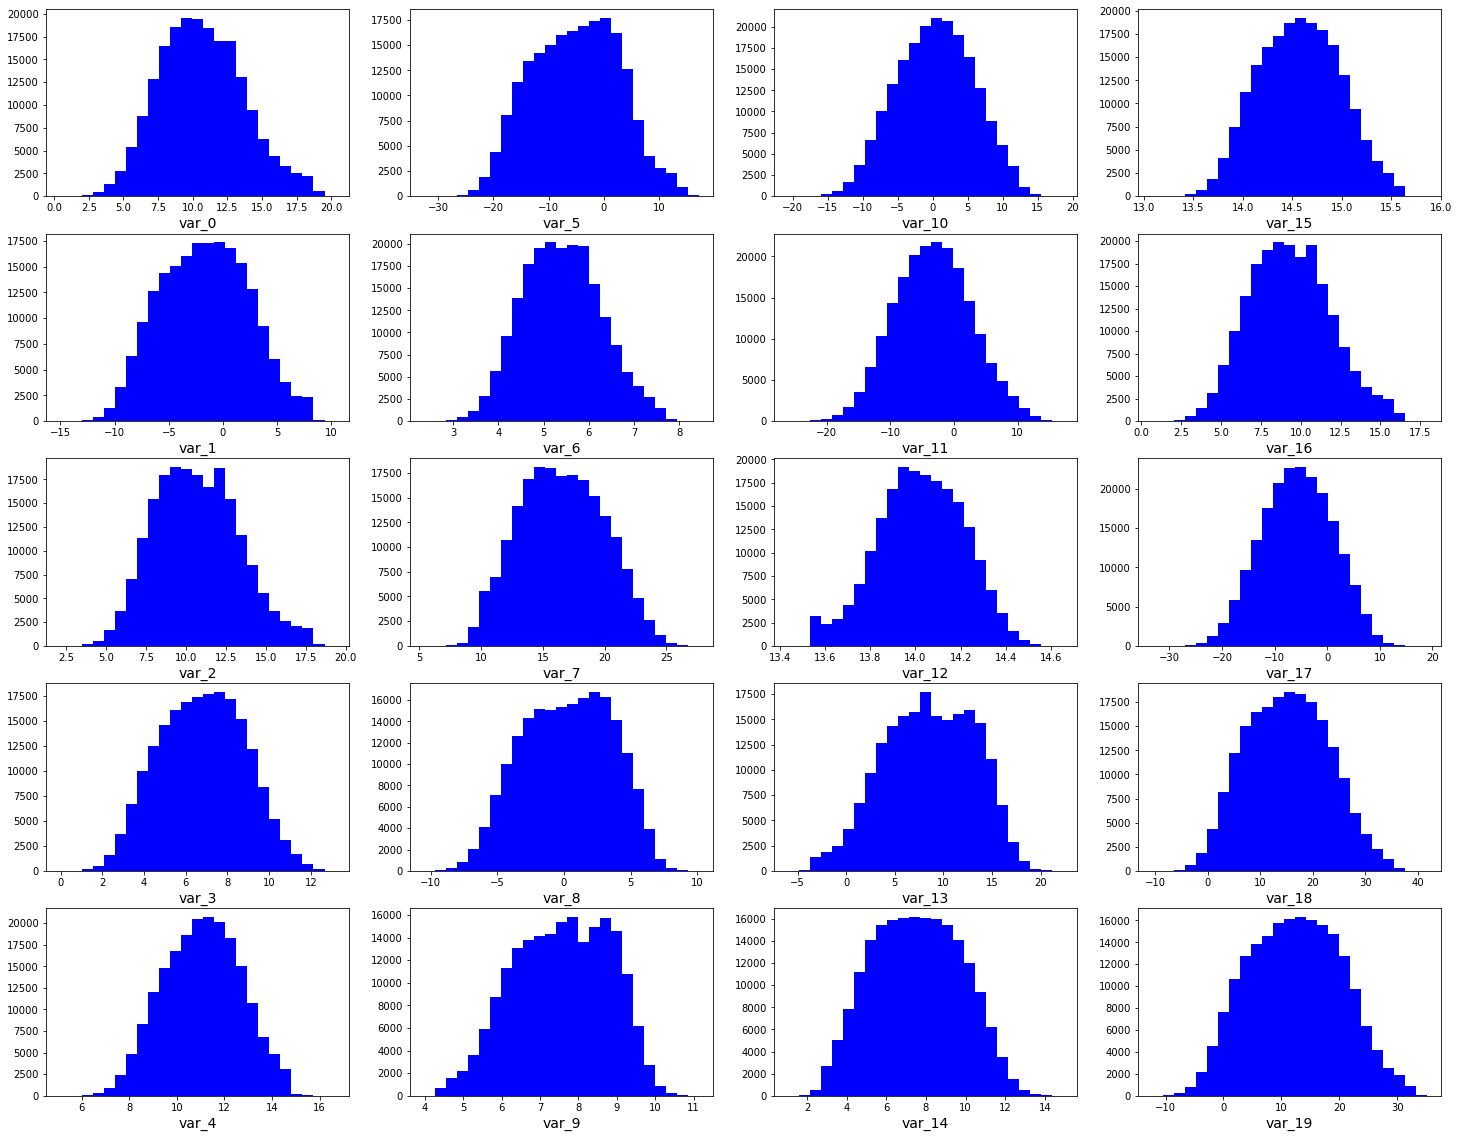

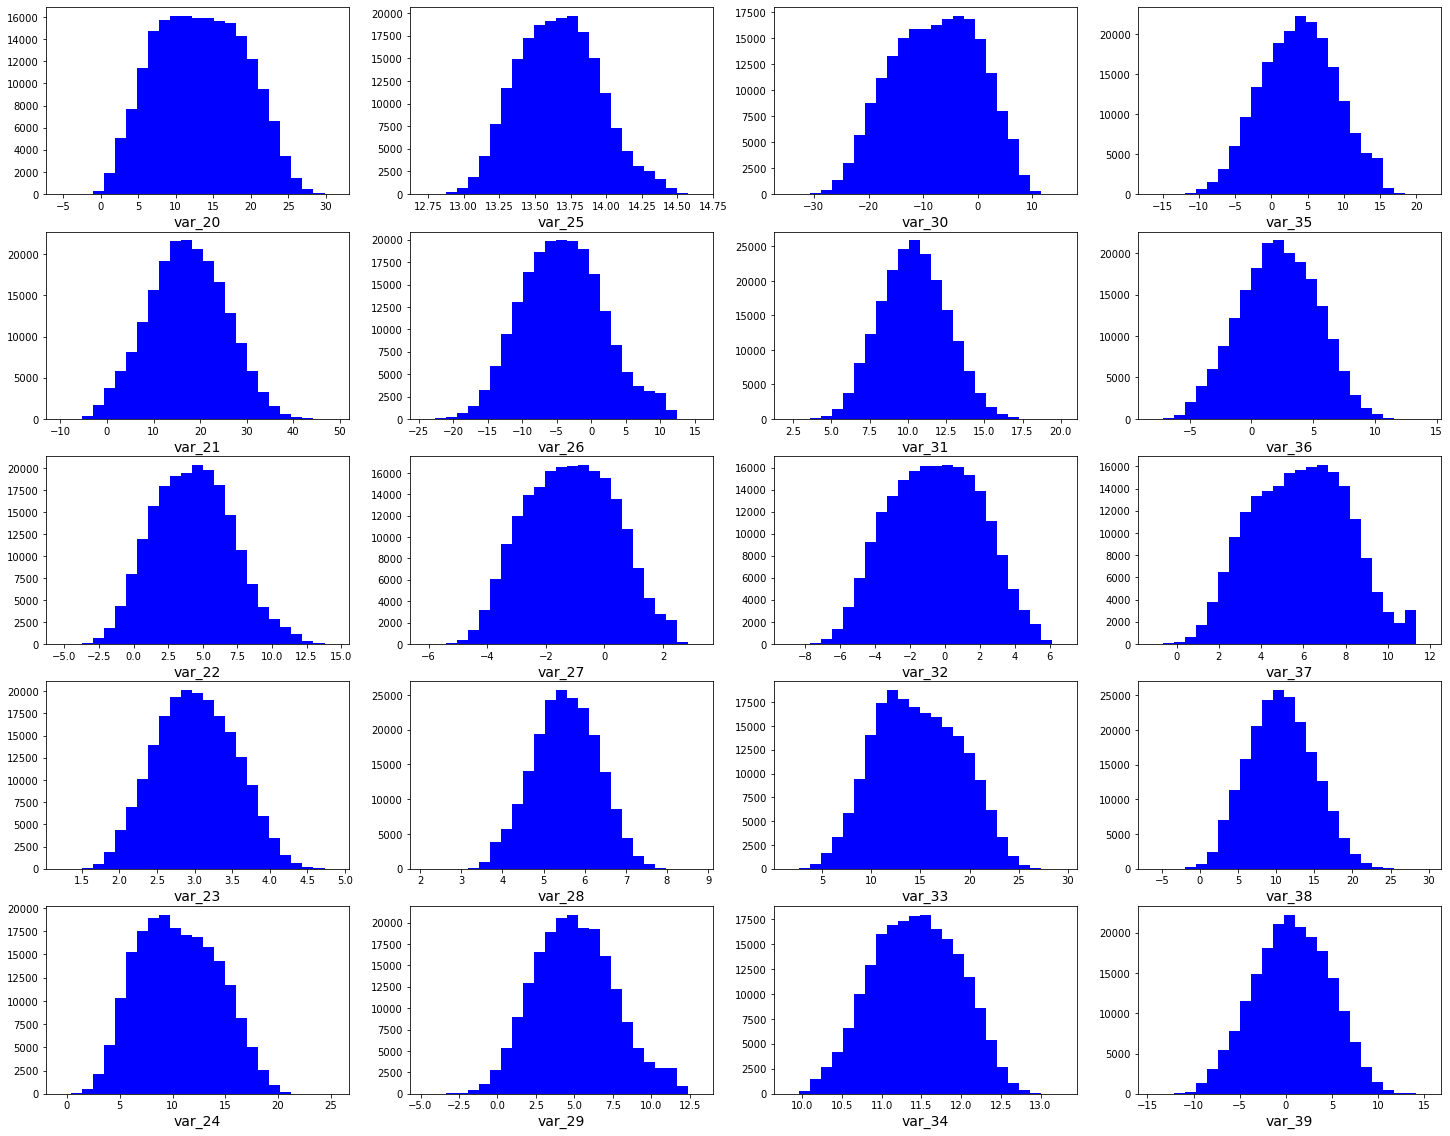

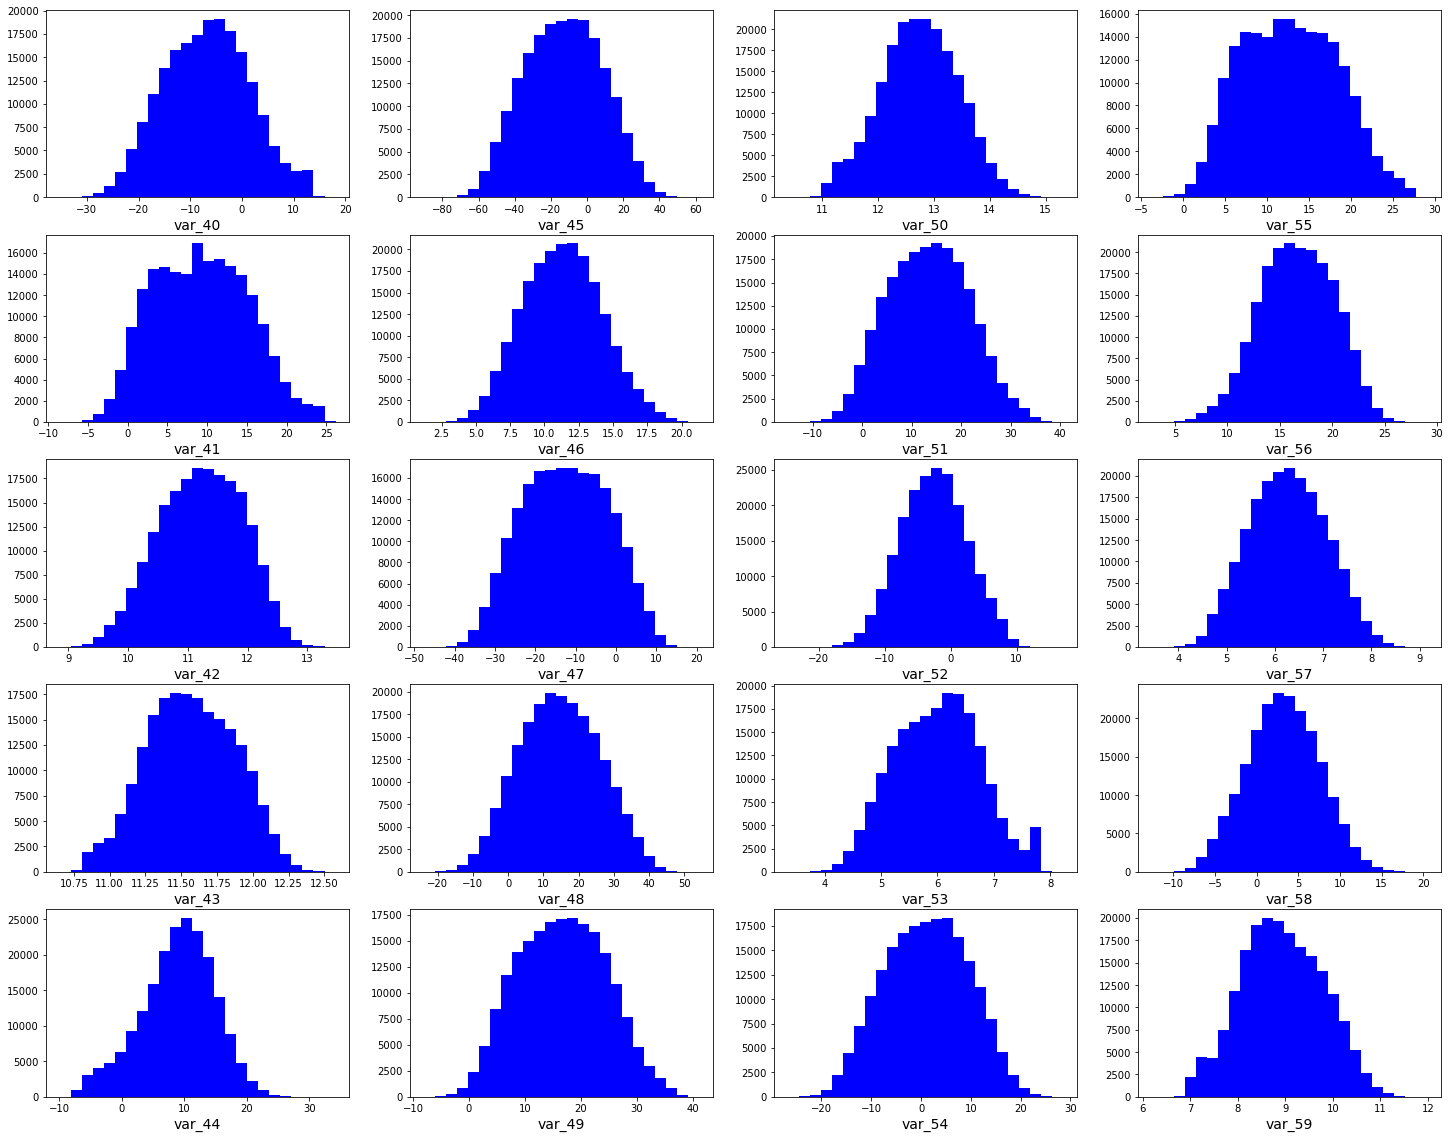

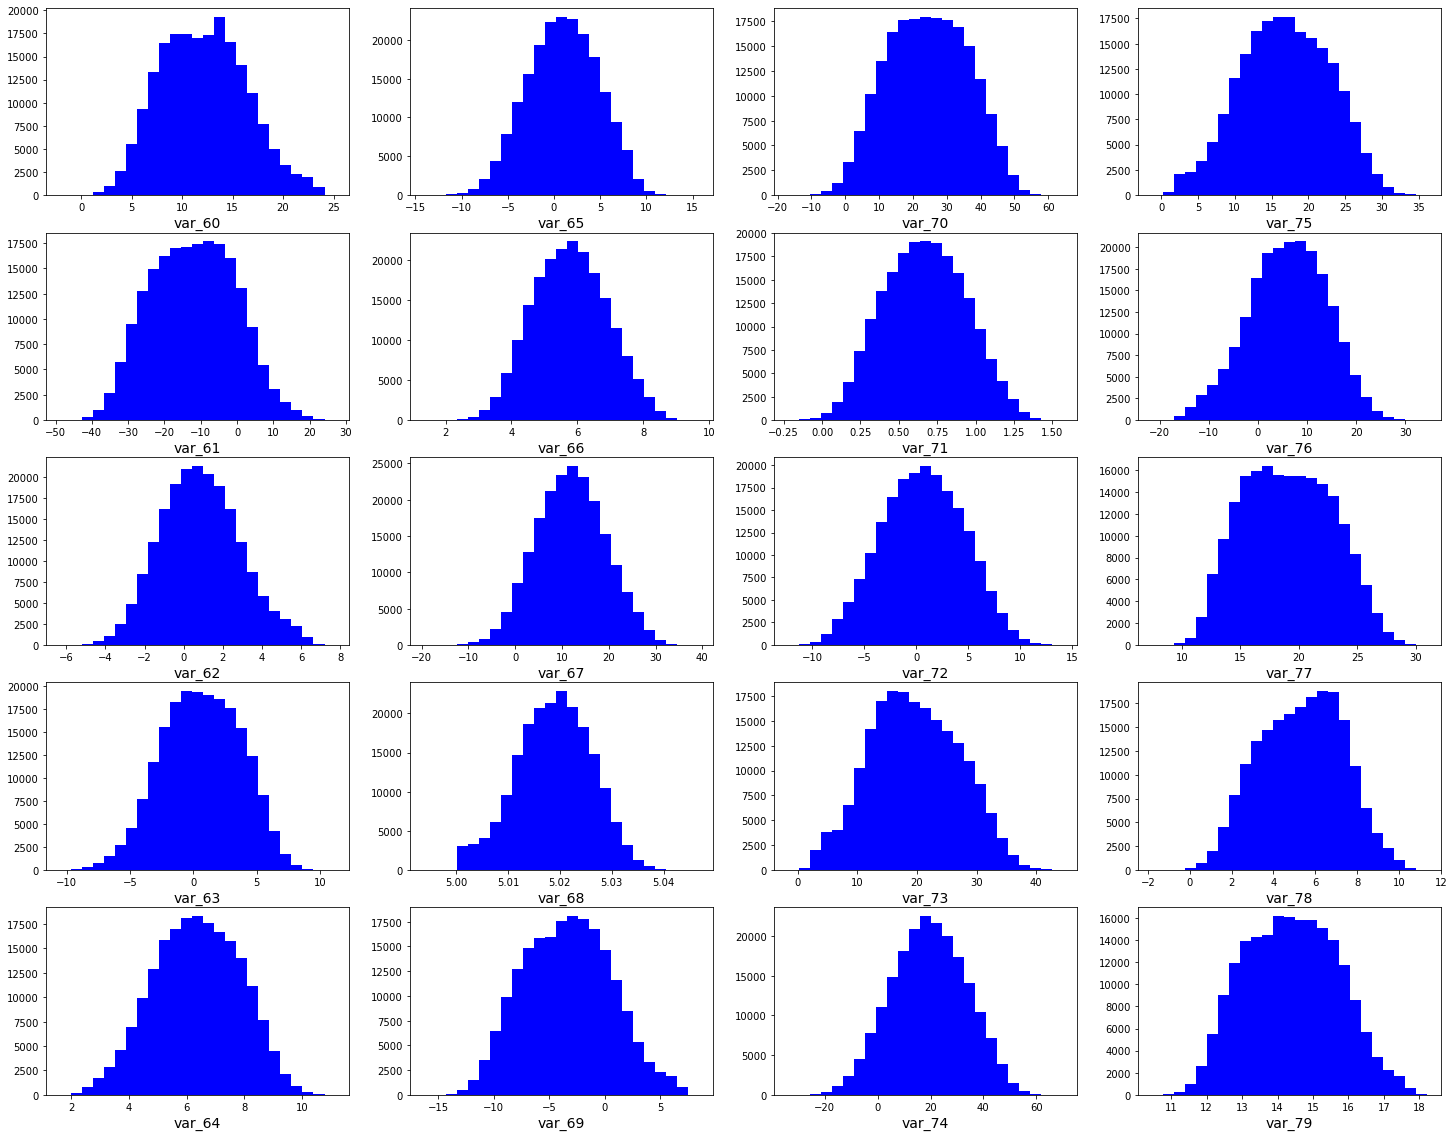

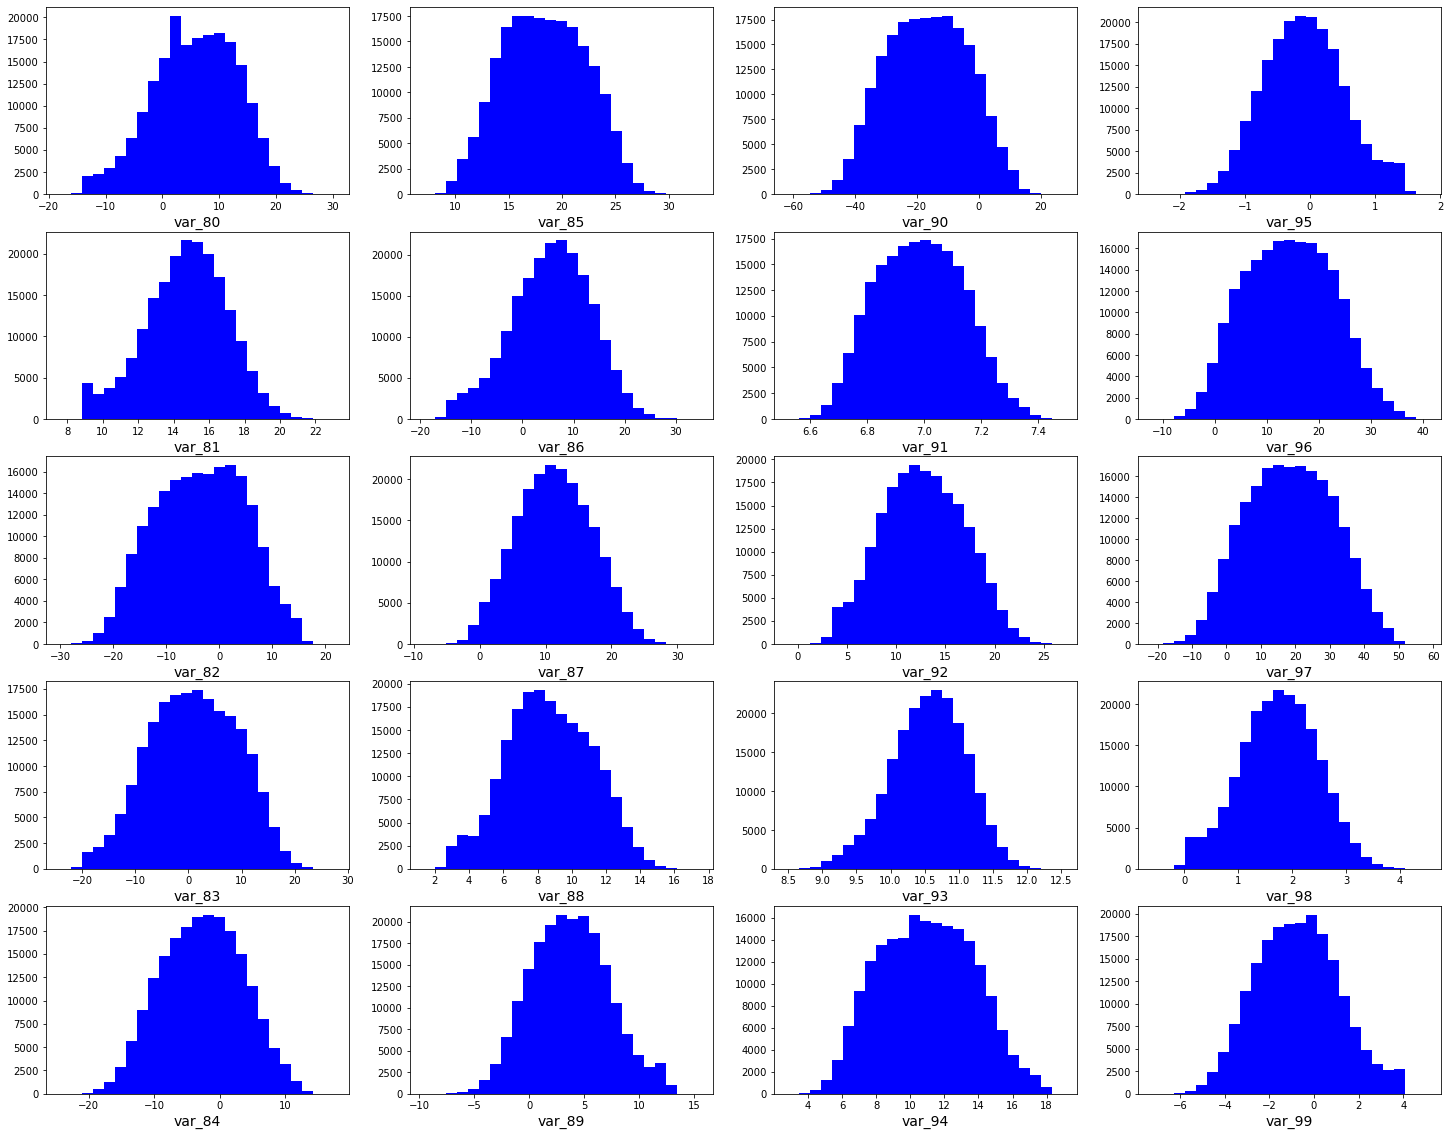

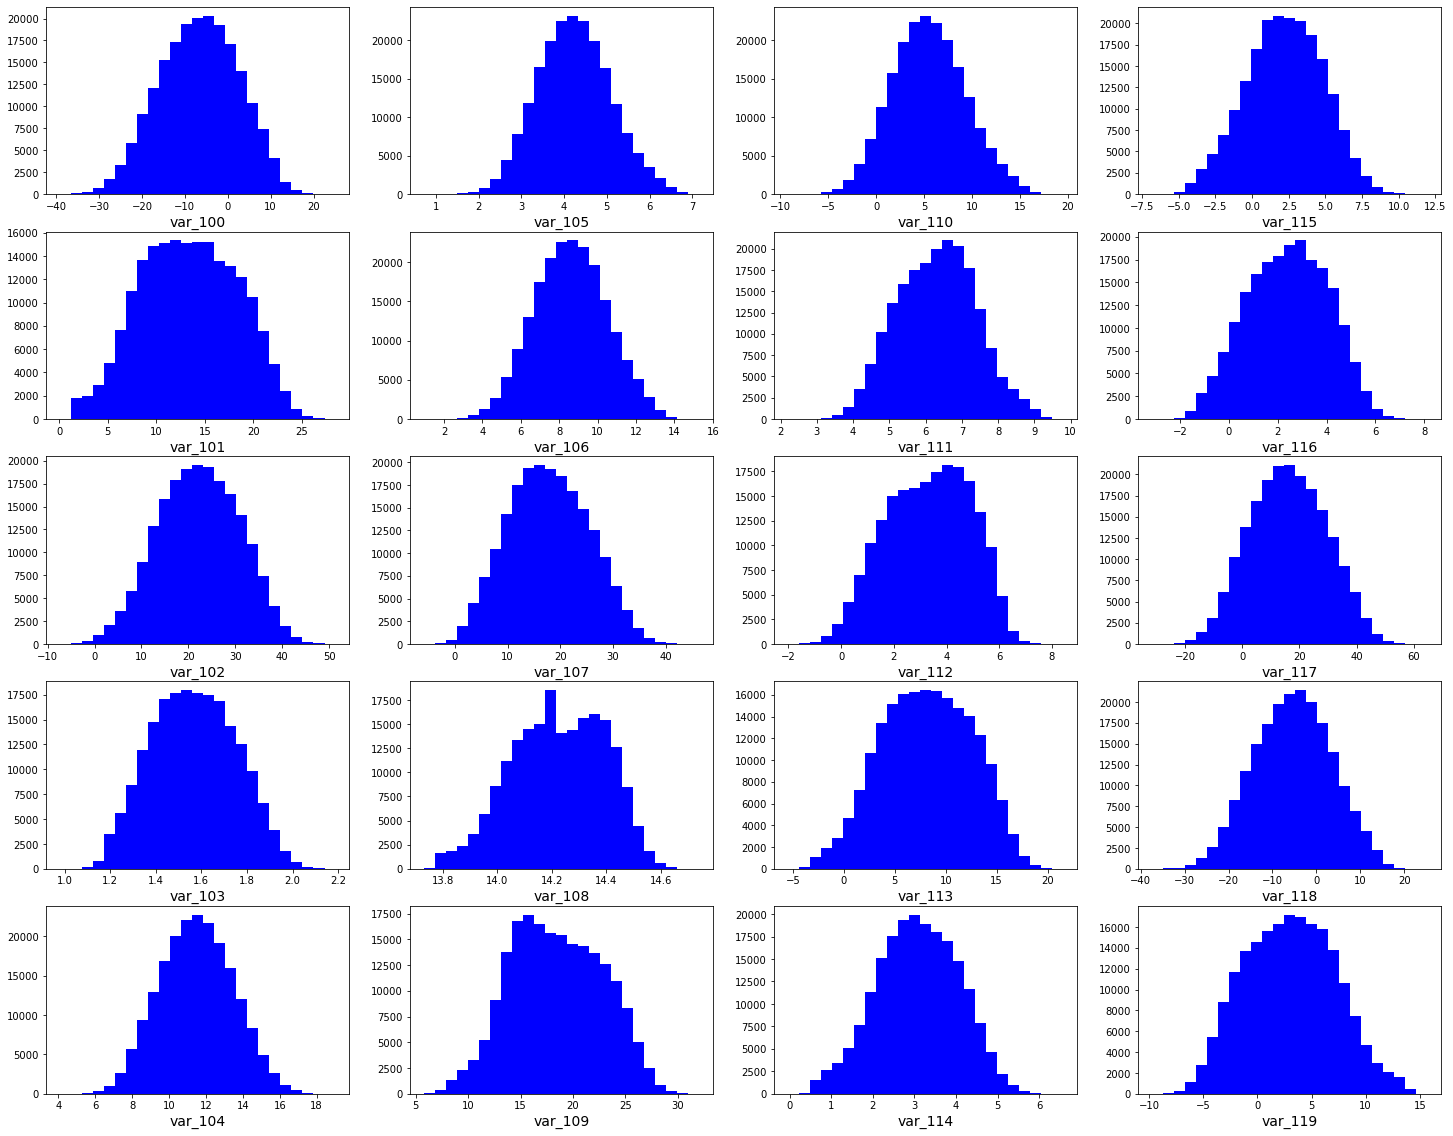

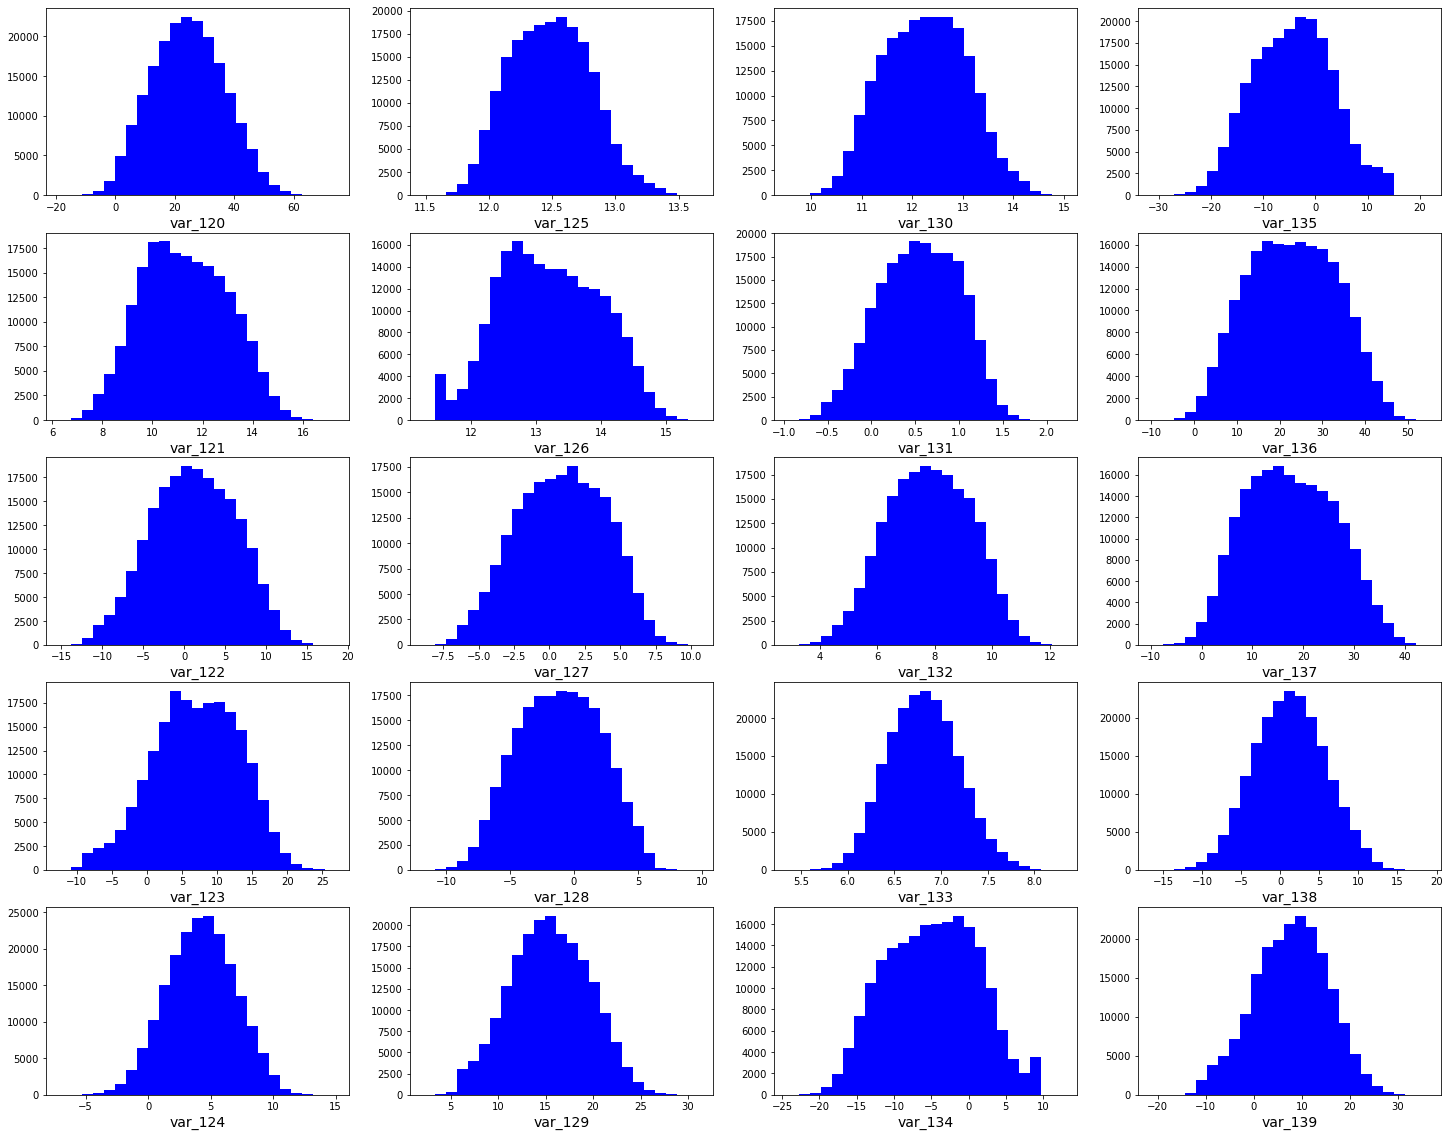

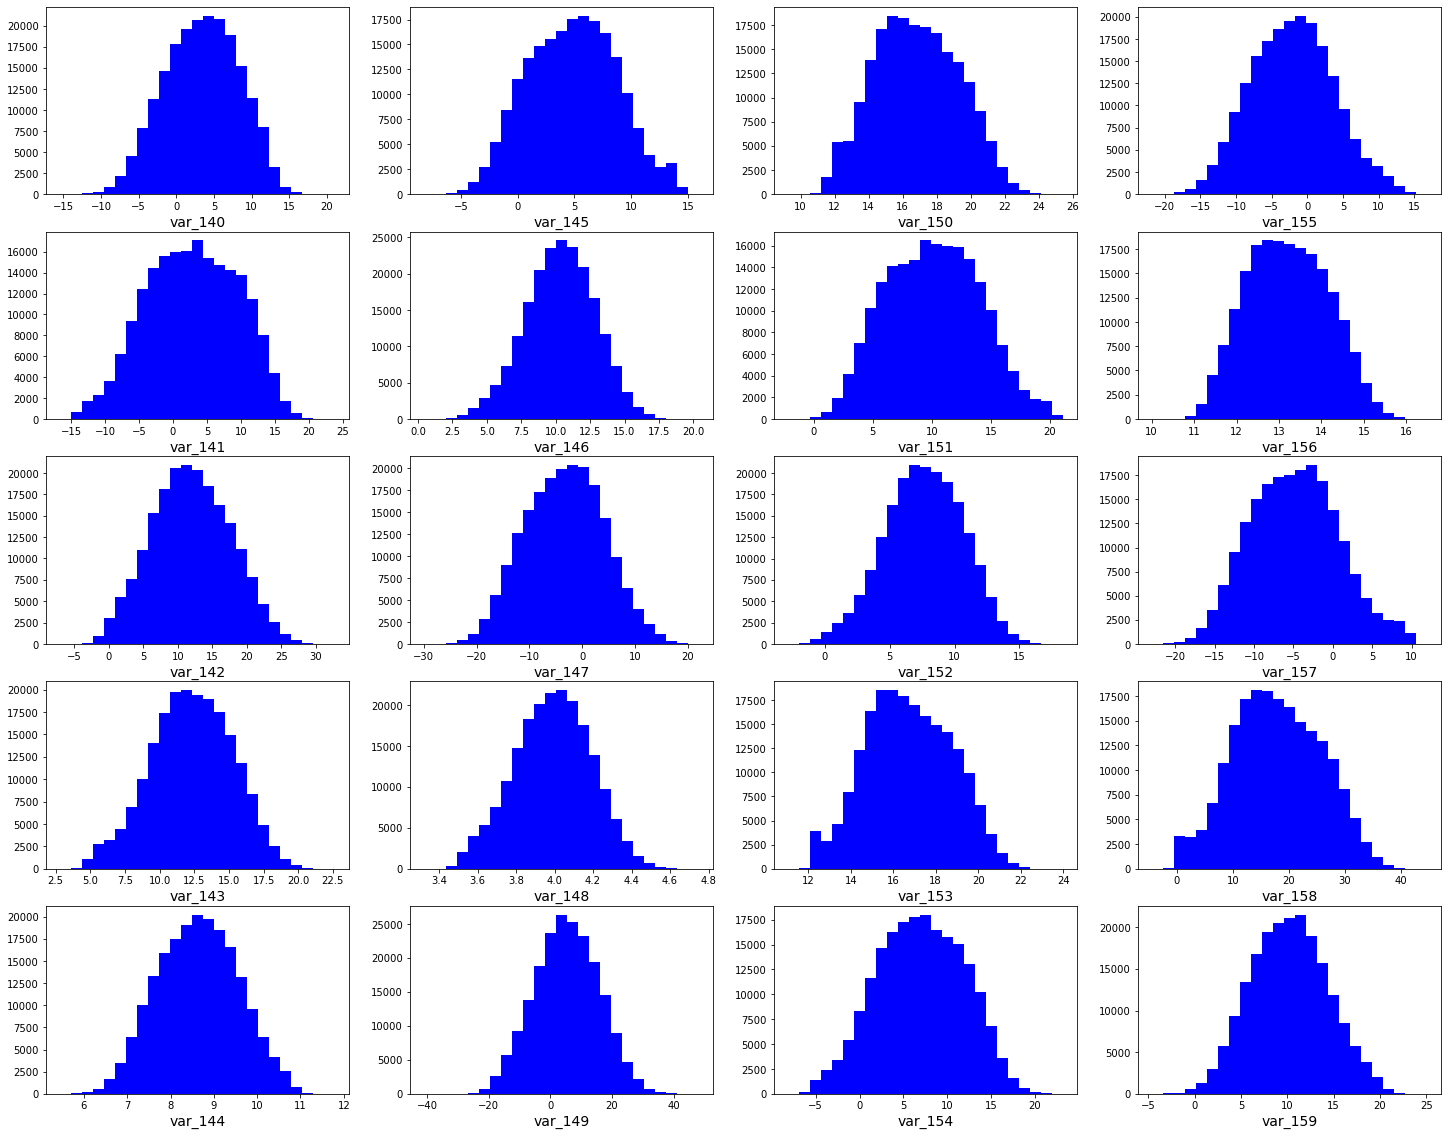

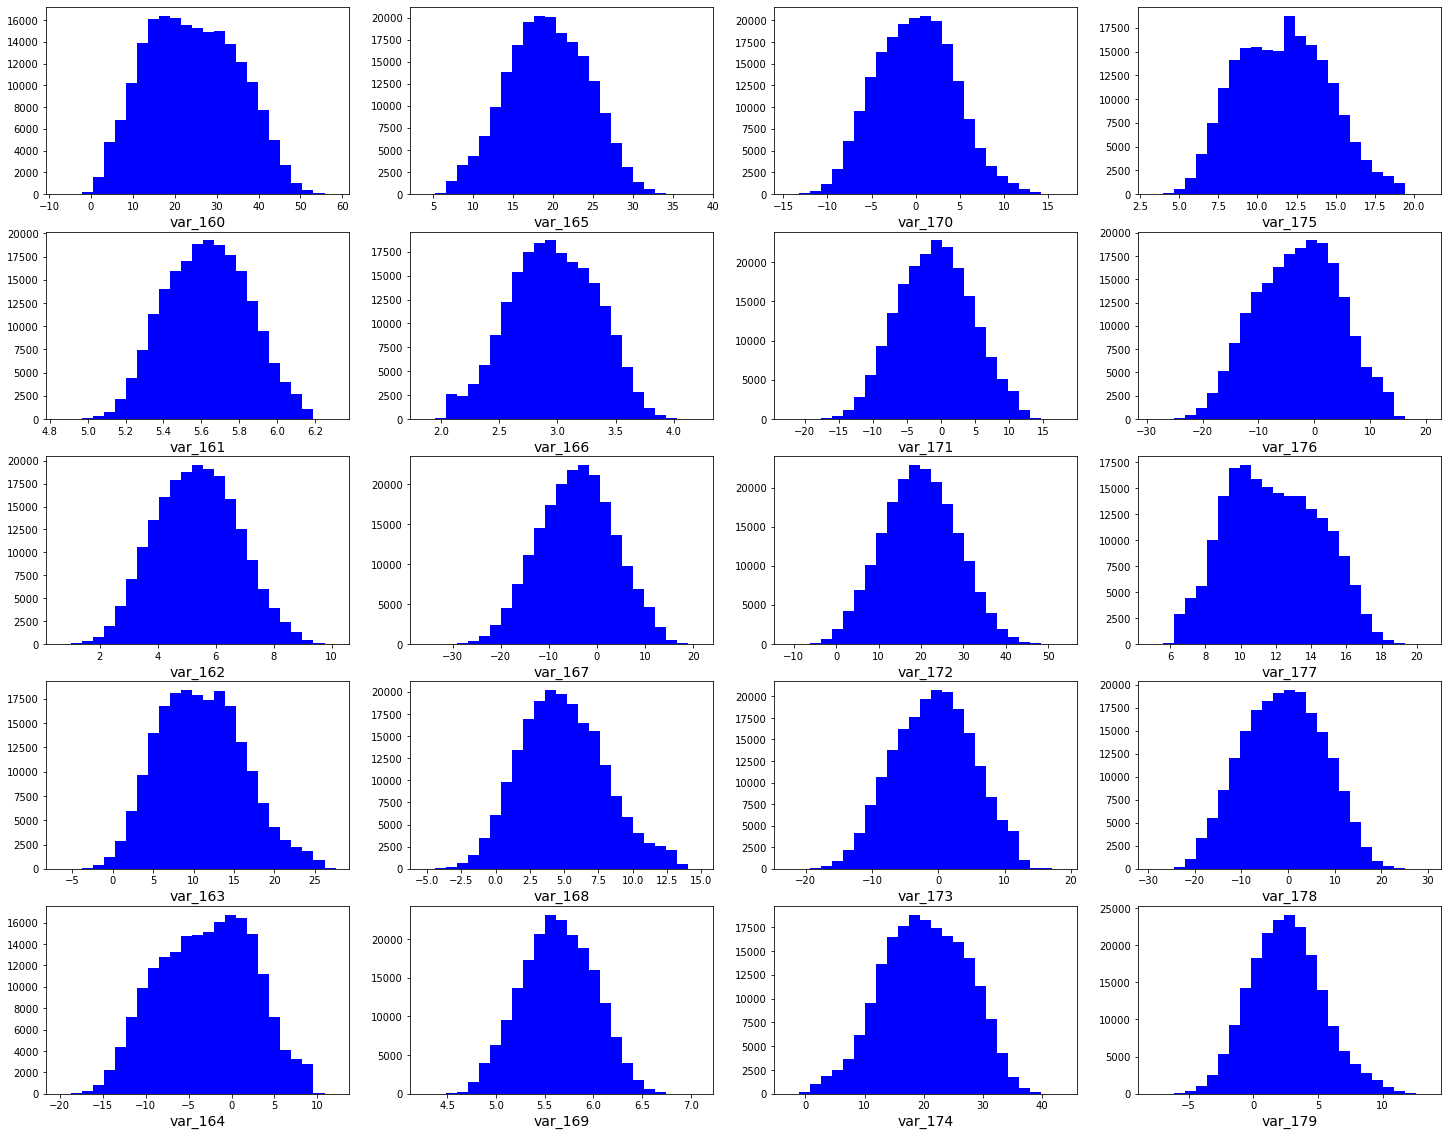

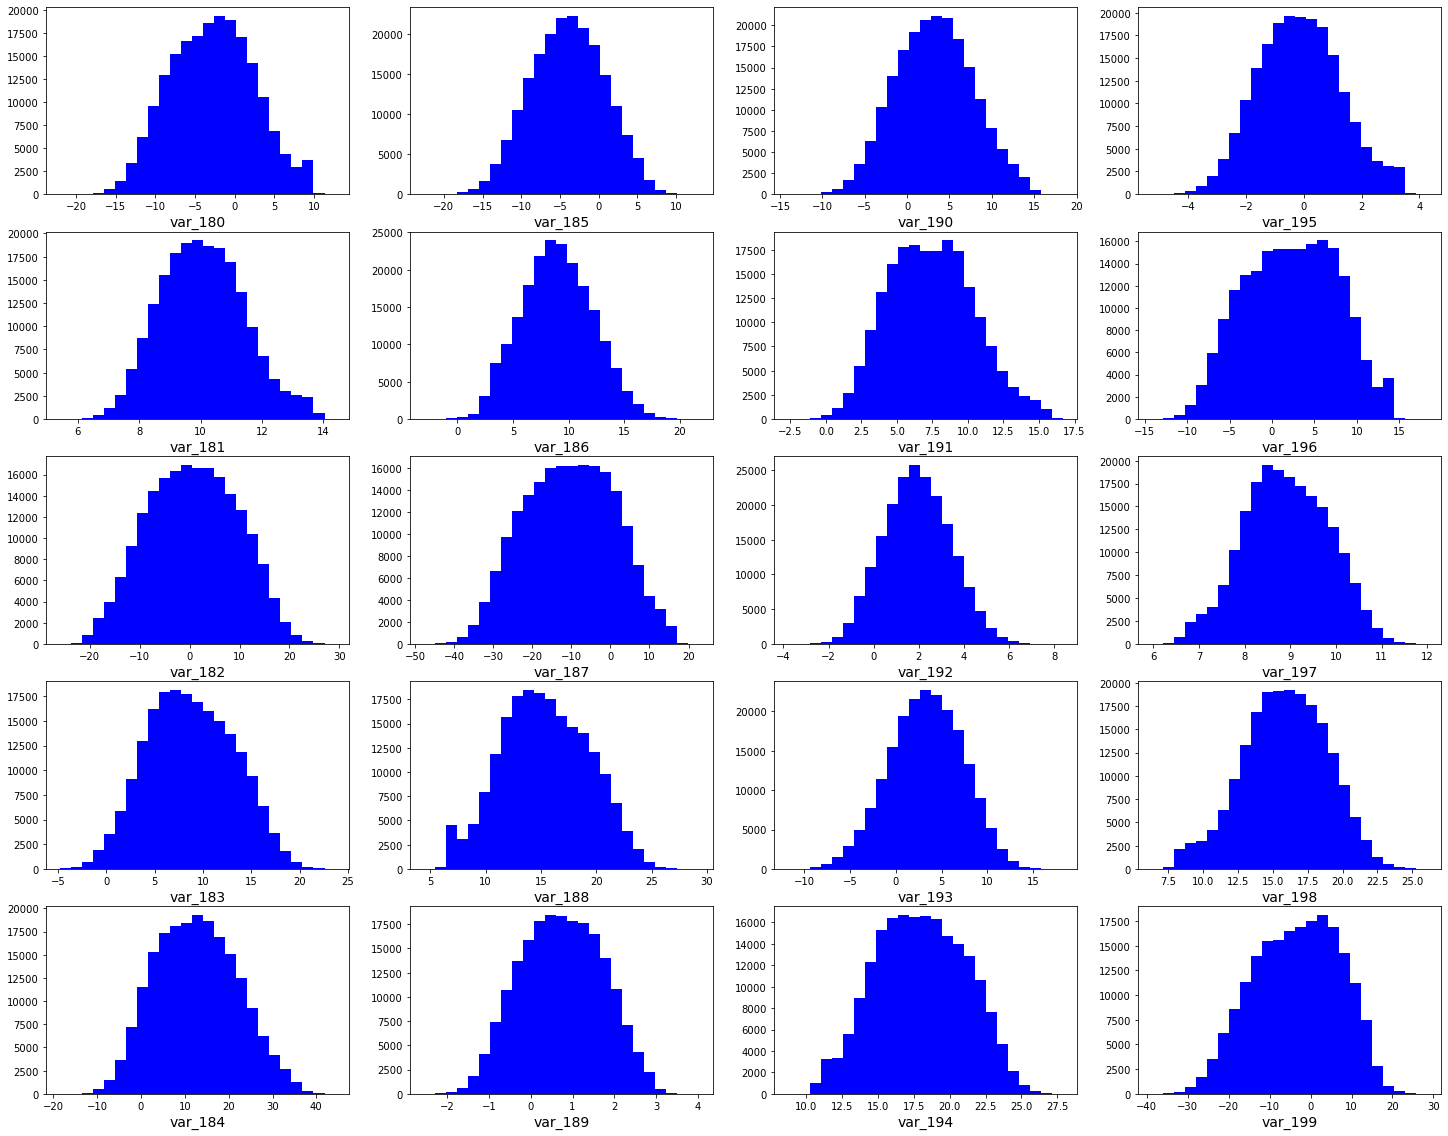

In [38]:
g = group(continuous_feature, 20)

for i in g:
    fig, axes = plt.subplots(5, 4, figsize=(25, 20))
    for num, feature in enumerate(list(i)):
        data = train[feature].copy()
        axes[num%5, num//5].hist(data, bins=25, color="blue")
        axes[num%5, num//5].set_xlabel(feature, fontsize=14)  

Признаки распределены нормально с небольшими отклонениями.

<AxesSubplot:>

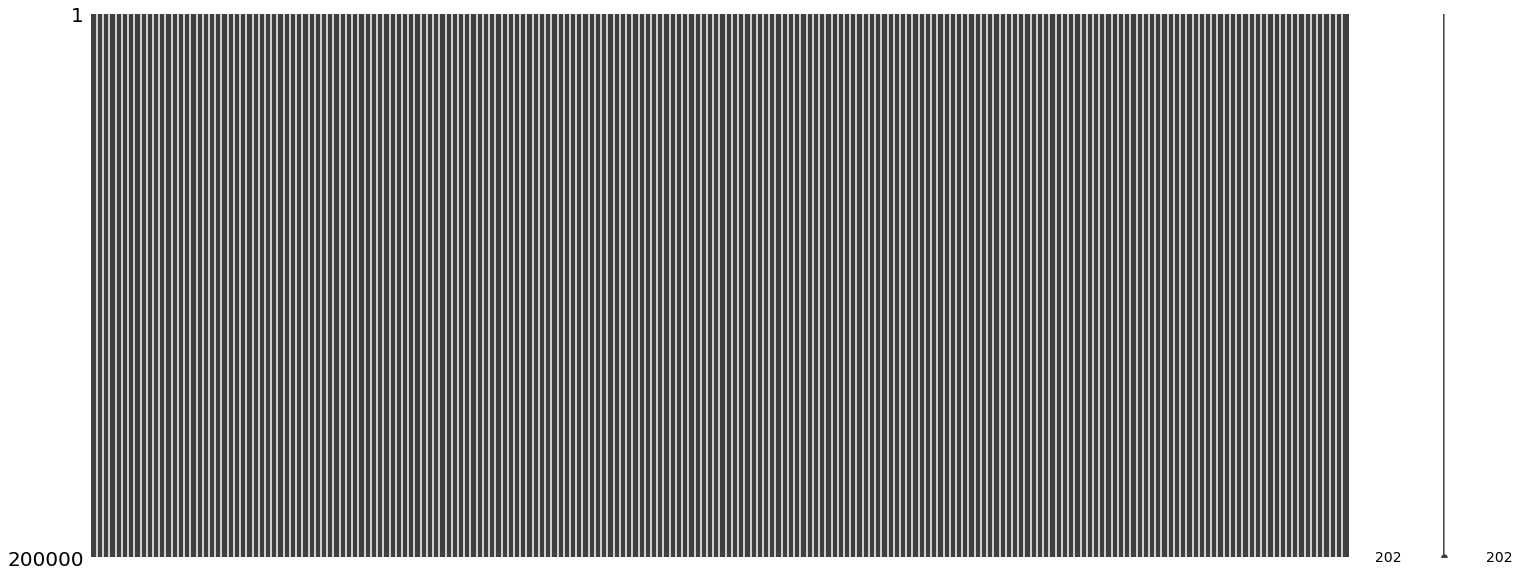

In [32]:
msno.matrix(train)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


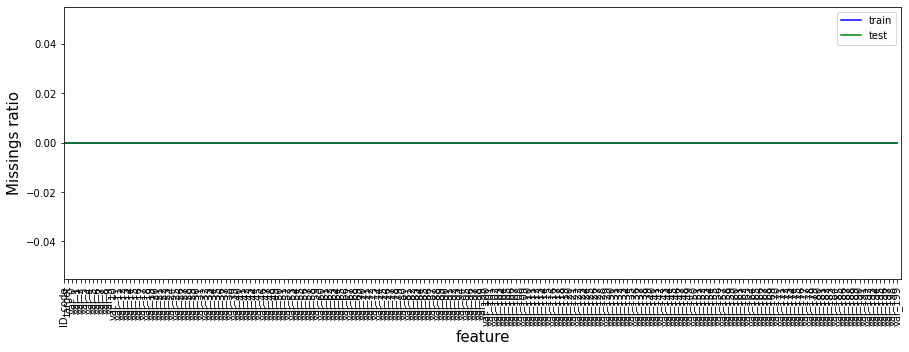

In [39]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train.isnull().mean(), label="train", color="blue")
plt.plot(test.isnull().mean(), label="test", color="green")
plt.xticks(range(train.shape[1]), train.columns, rotation=90)
plt.ylabel("Missings ratio", size=15)
plt.xlabel("feature", size=15)
plt.xlim(0, train.shape[1])
plt.legend(loc="best")

Пропусков не обнаружено

Задание 2: Сделать базовый анализ целевой переменной, сделать выводы;

In [40]:
target = train["target"]
target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

Целевая переменная представлена только числами 1 и 0. С преобладанием 0.

Задание 3: Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

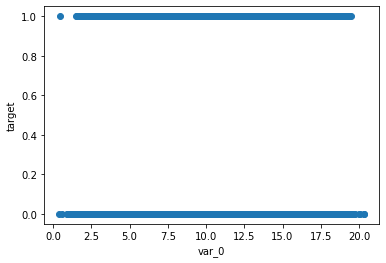

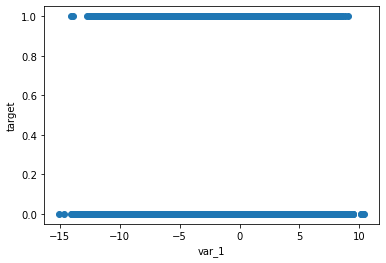

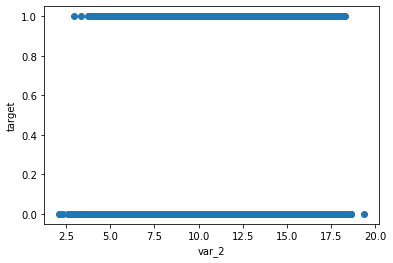

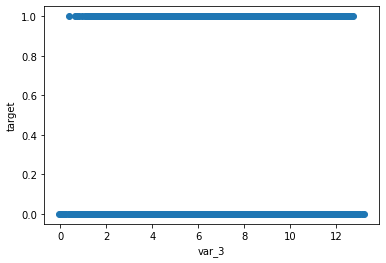

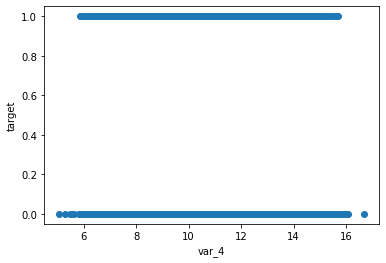

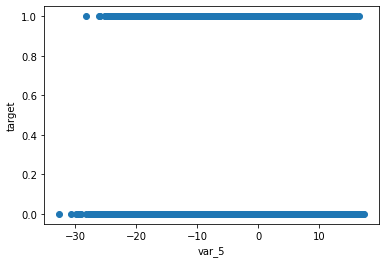

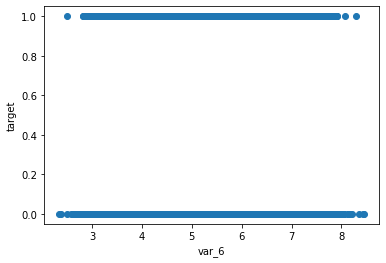

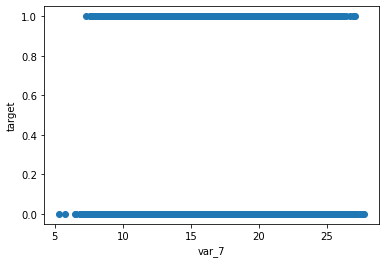

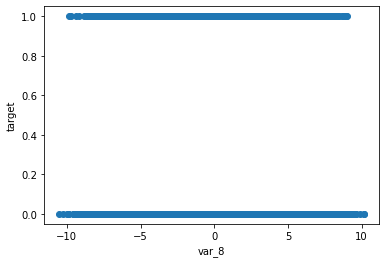

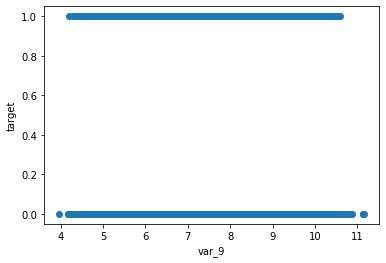

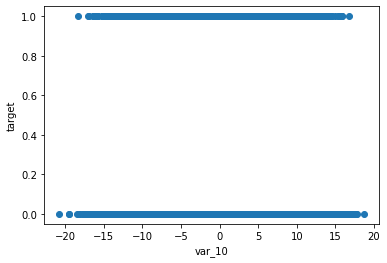

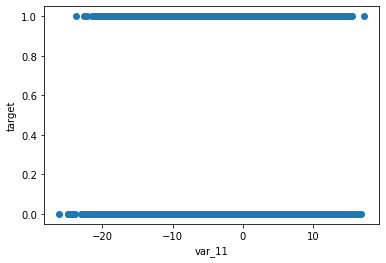

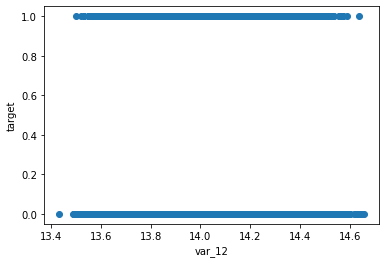

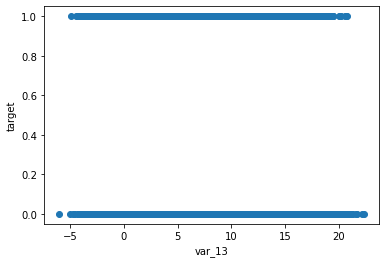

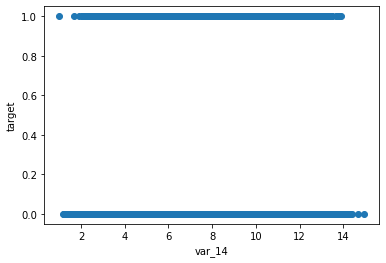

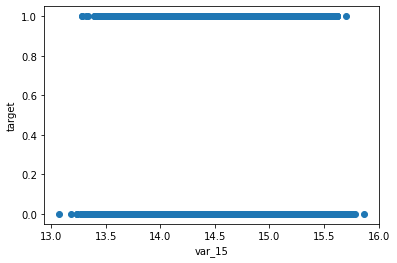

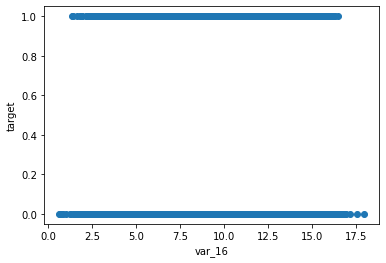

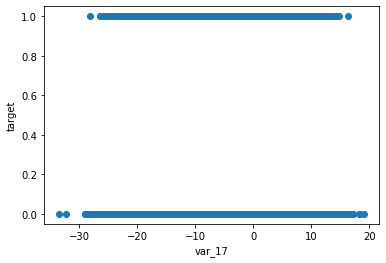

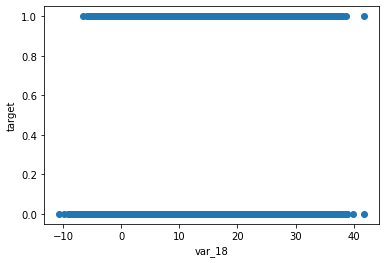

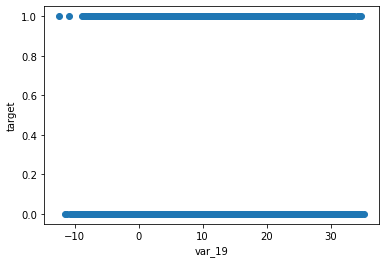

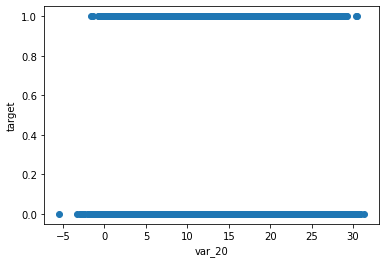

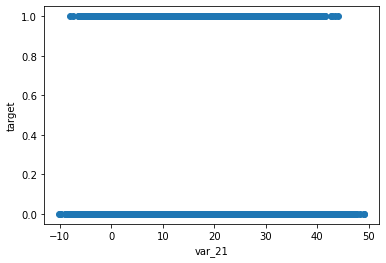

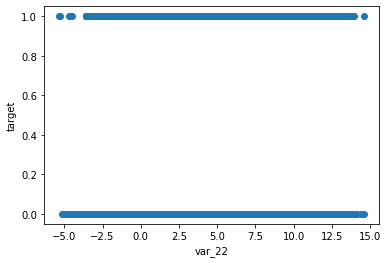

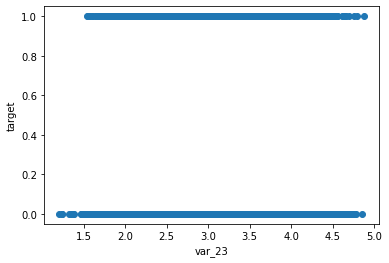

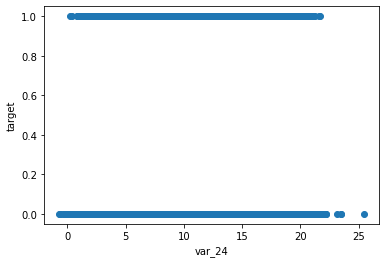

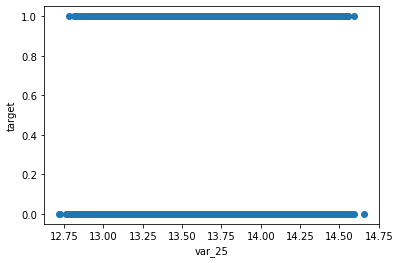

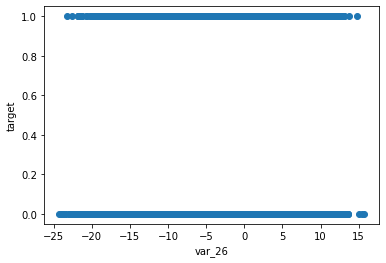

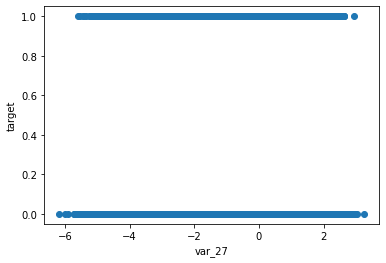

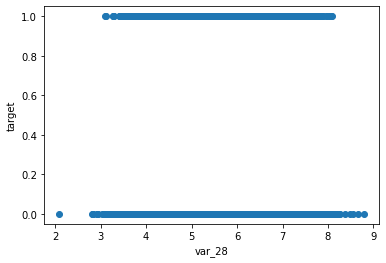

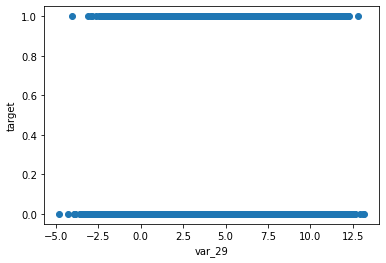

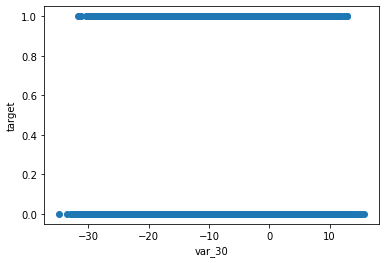

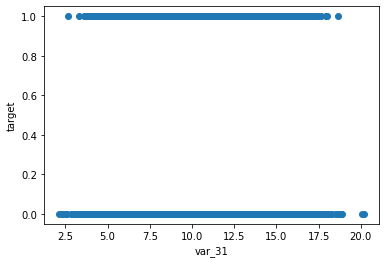

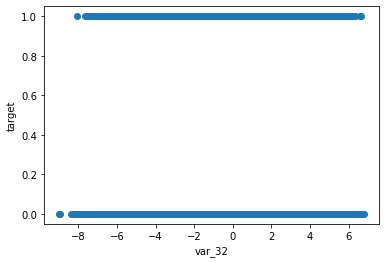

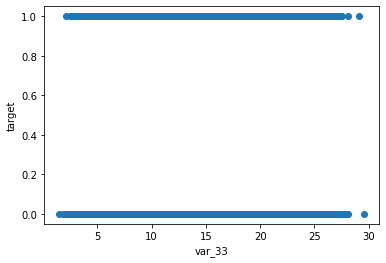

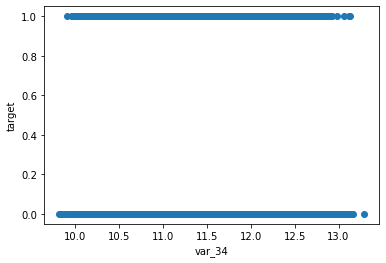

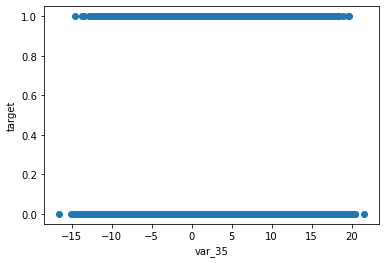

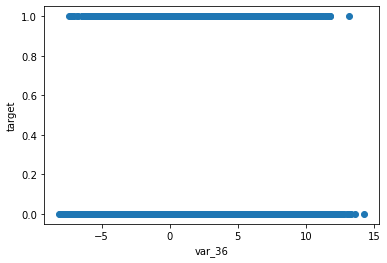

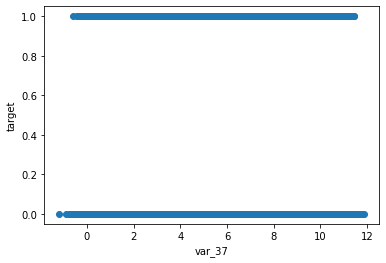

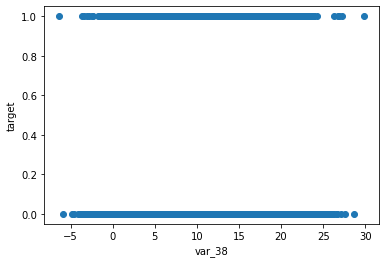

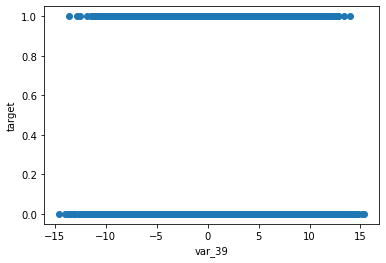

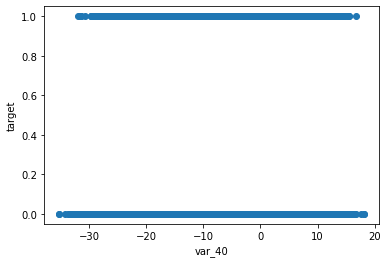

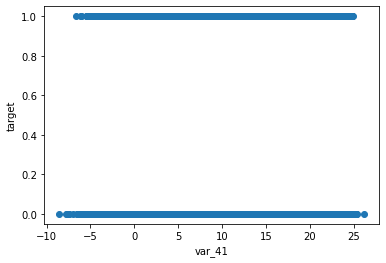

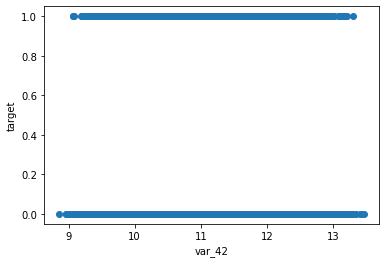

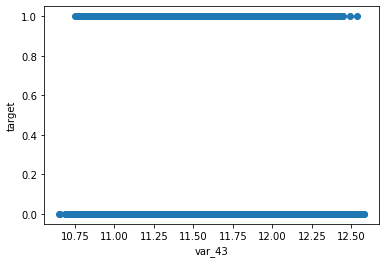

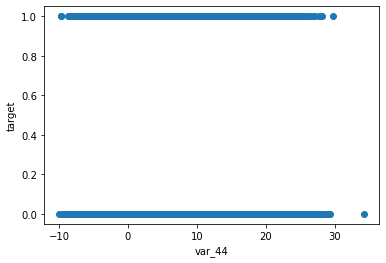

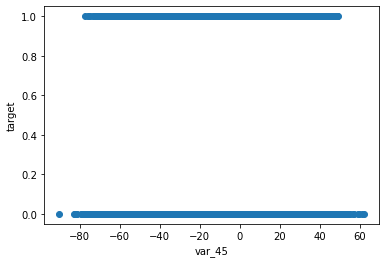

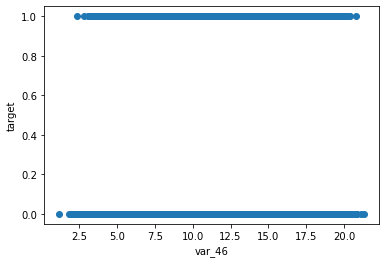

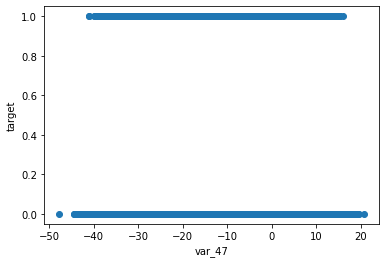

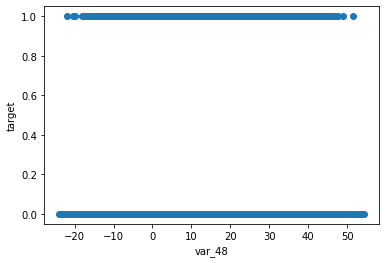

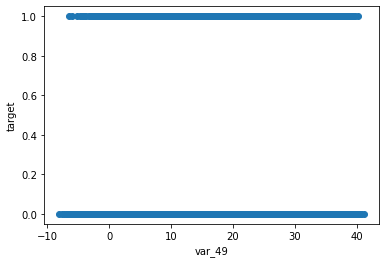

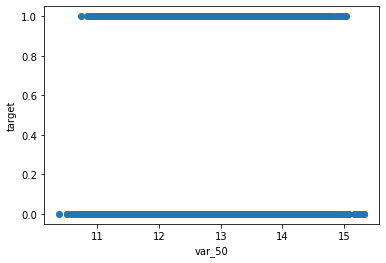

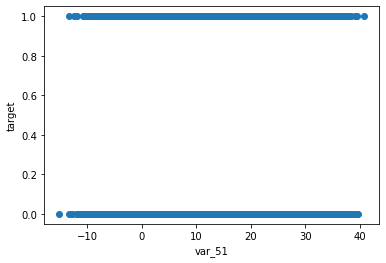

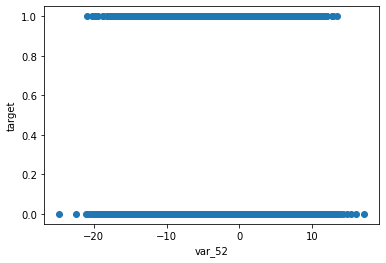

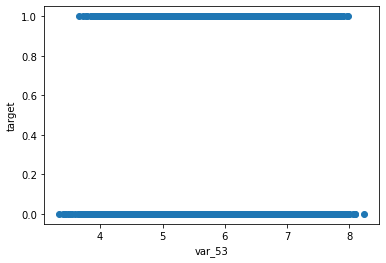

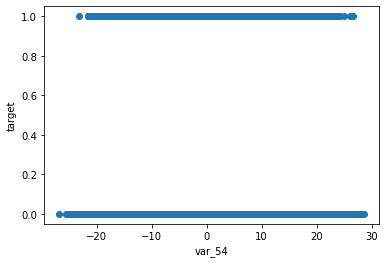

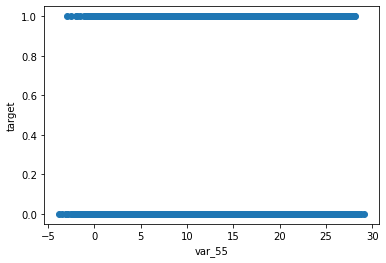

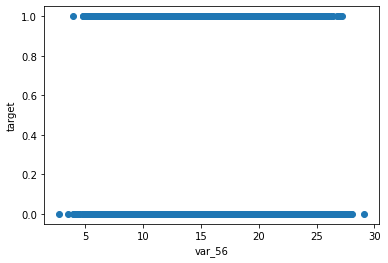

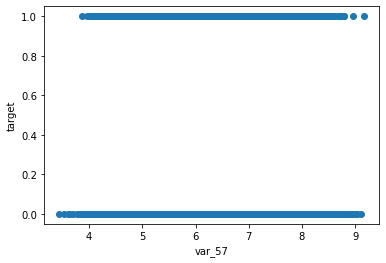

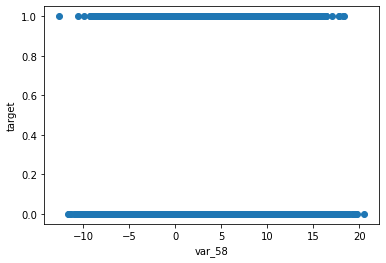

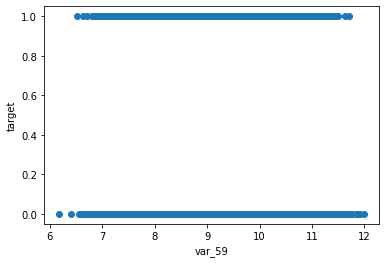

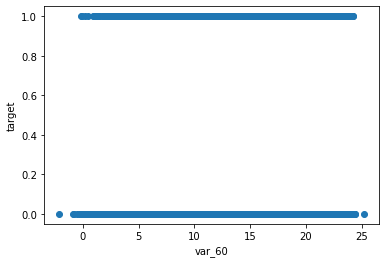

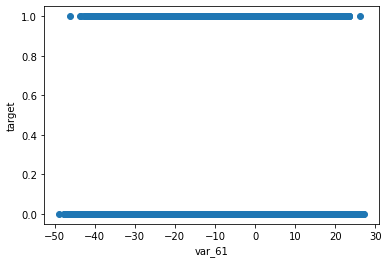

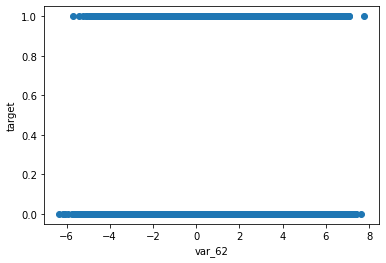

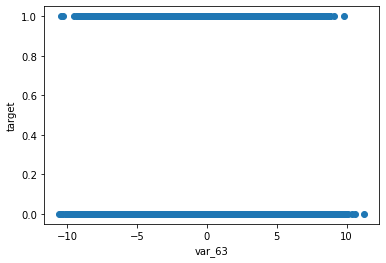

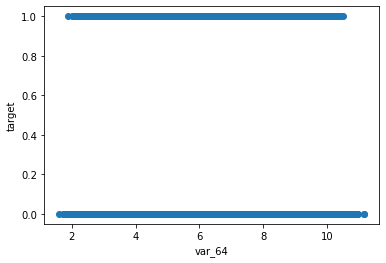

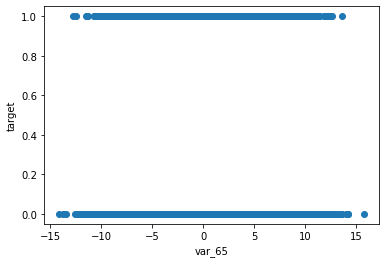

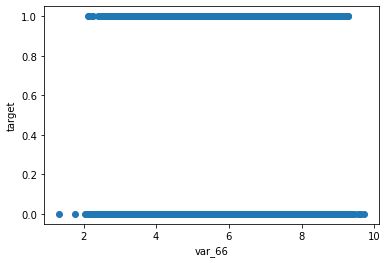

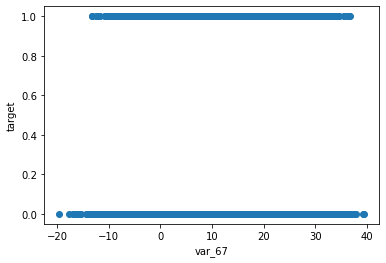

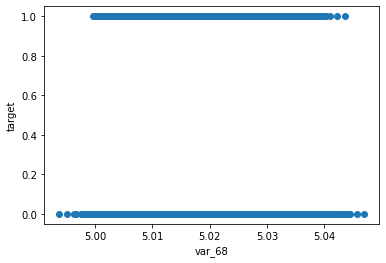

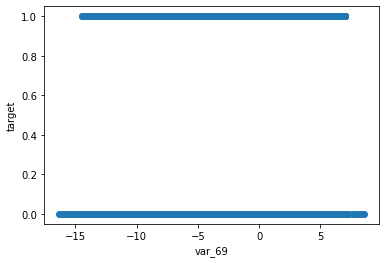

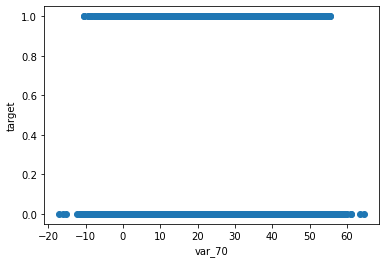

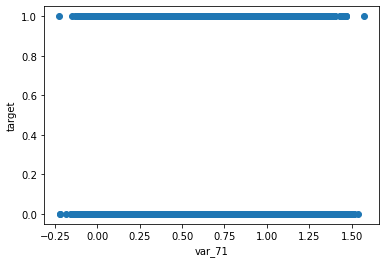

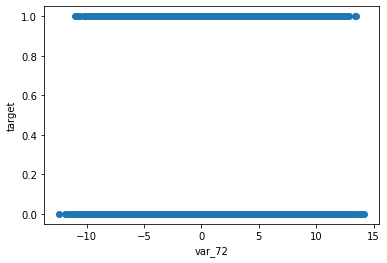

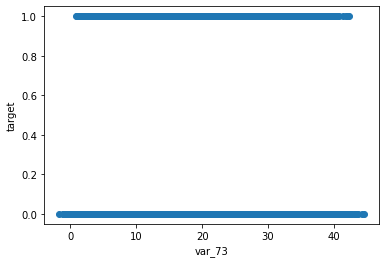

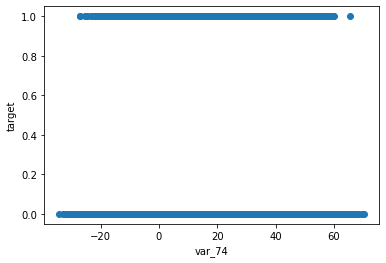

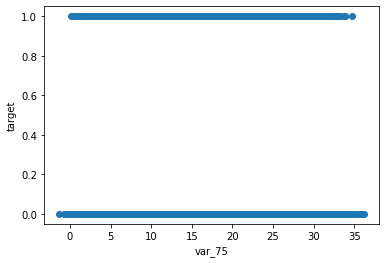

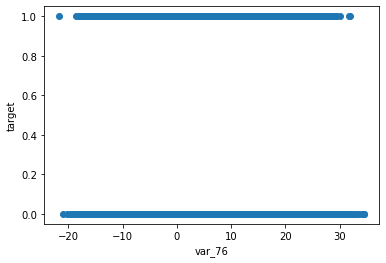

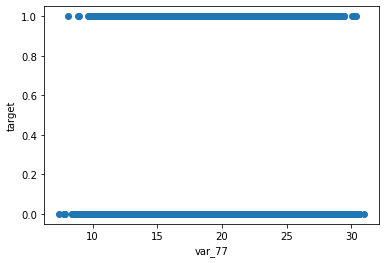

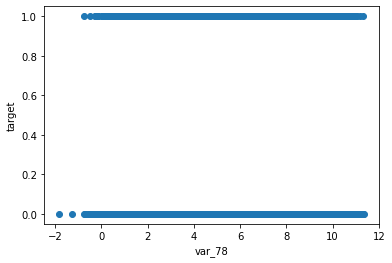

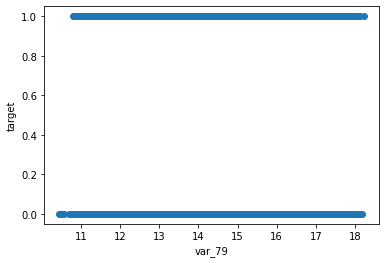

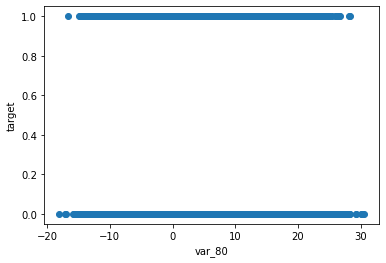

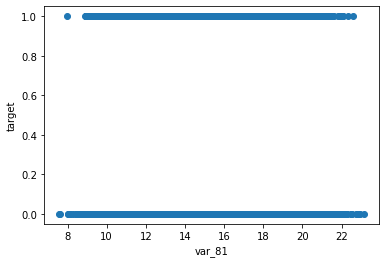

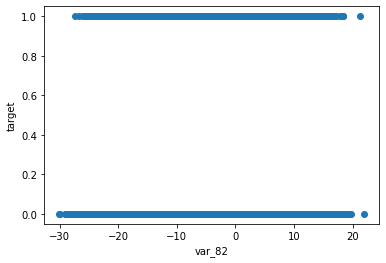

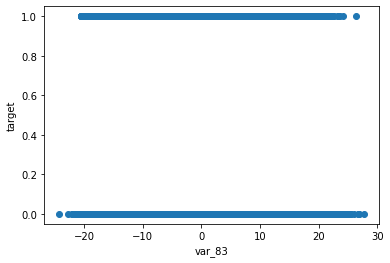

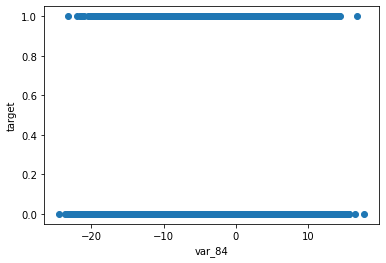

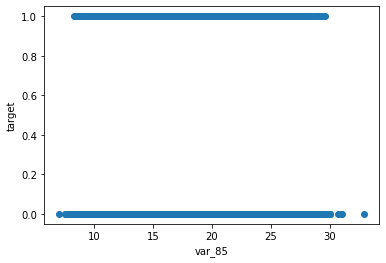

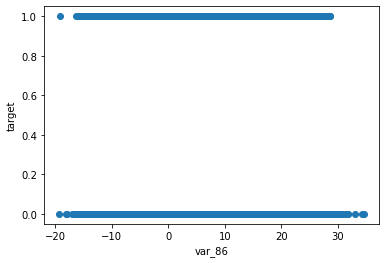

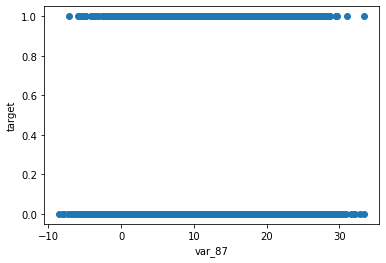

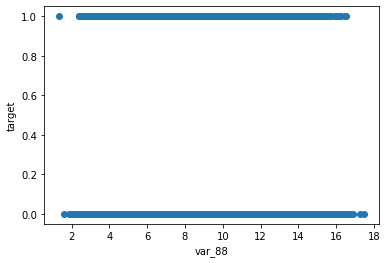

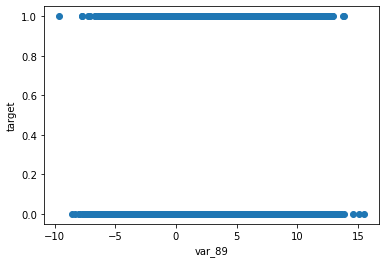

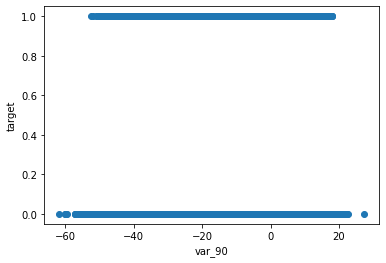

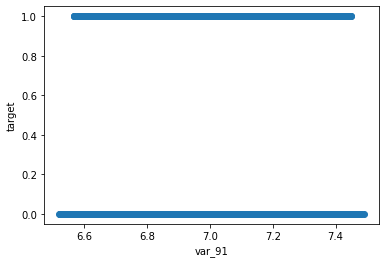

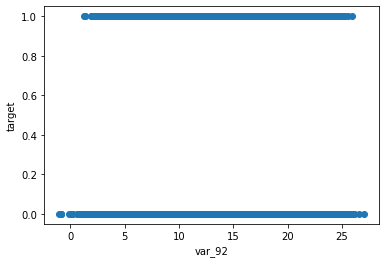

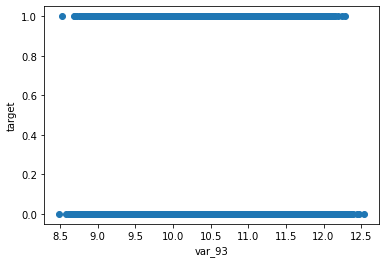

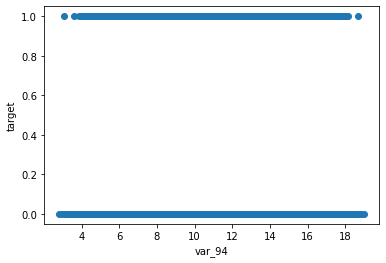

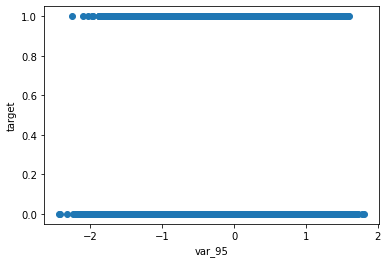

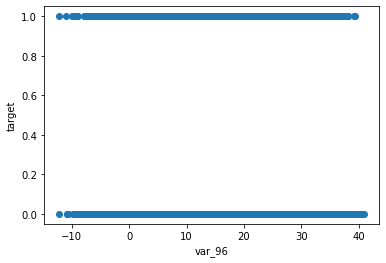

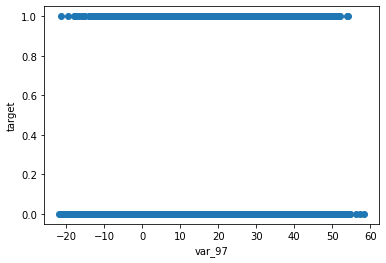

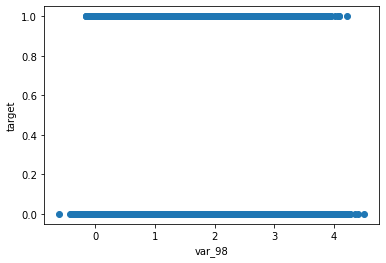

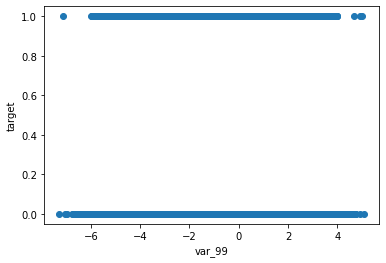

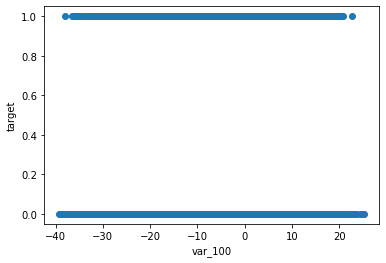

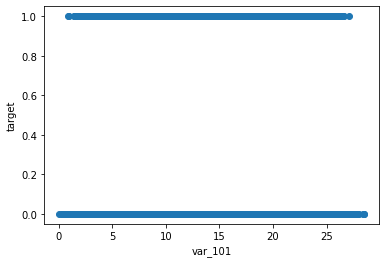

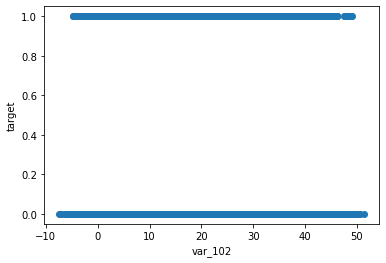

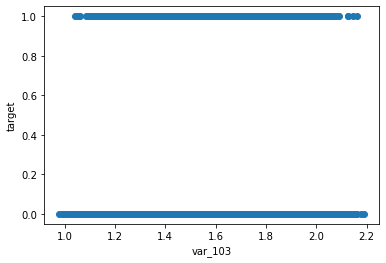

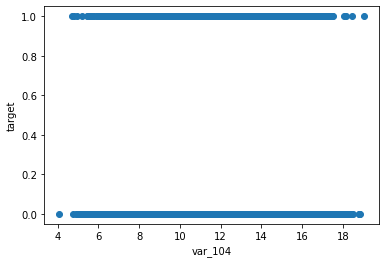

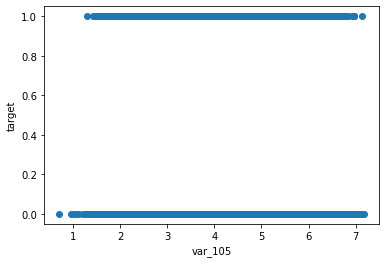

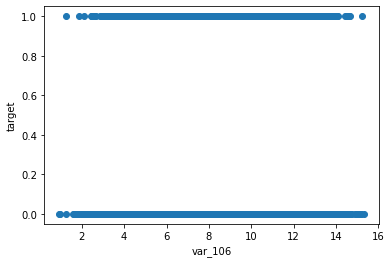

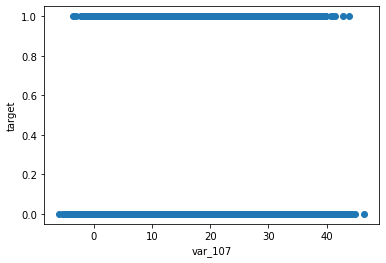

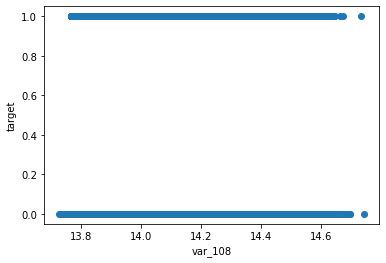

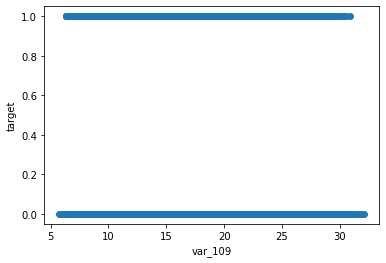

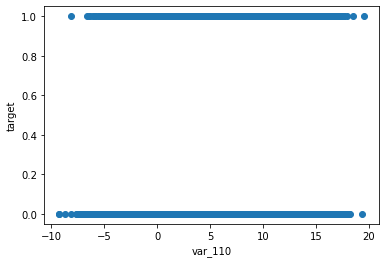

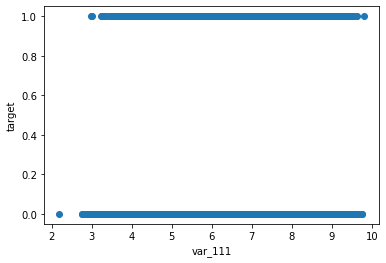

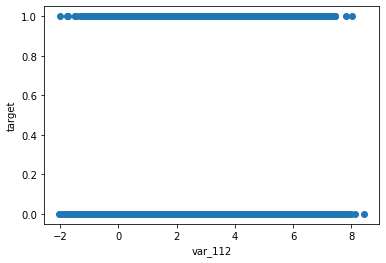

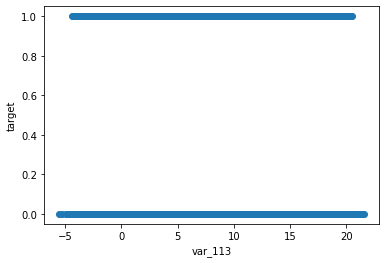

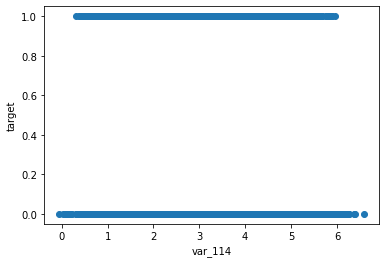

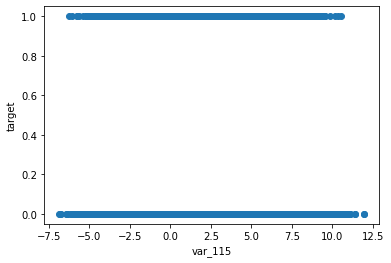

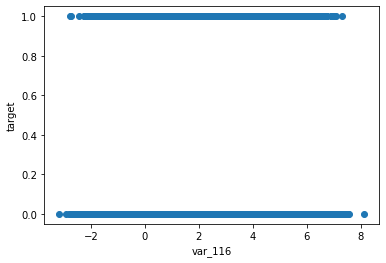

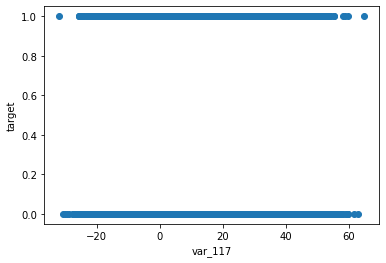

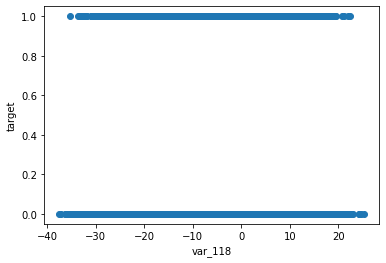

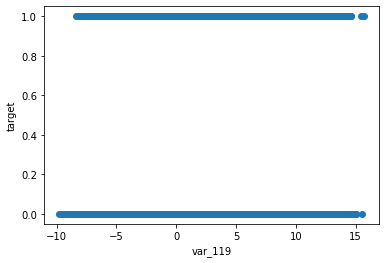

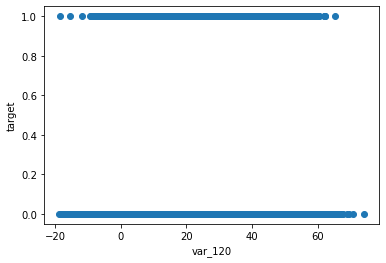

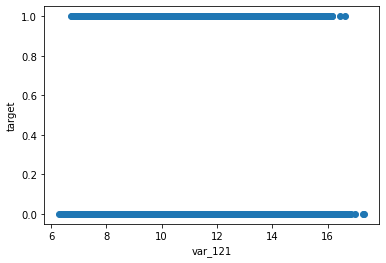

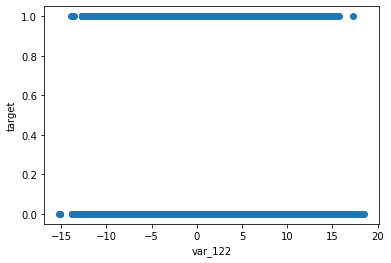

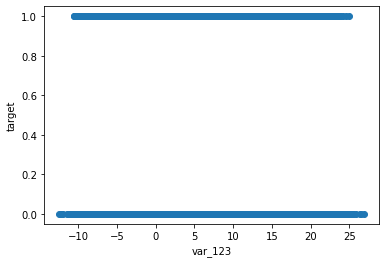

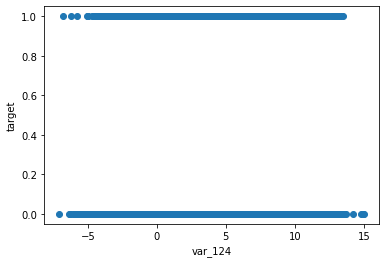

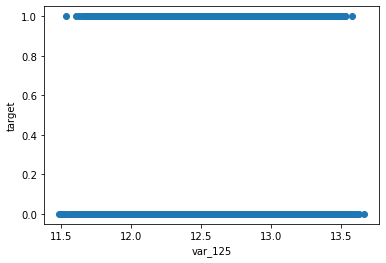

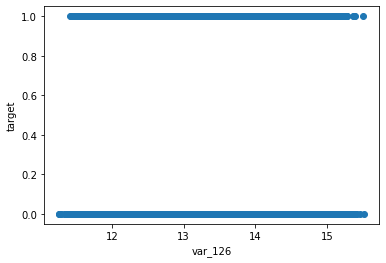

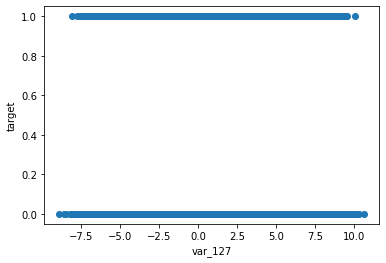

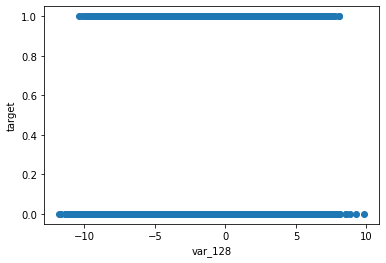

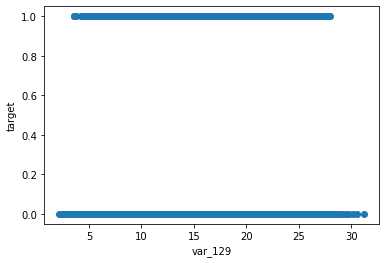

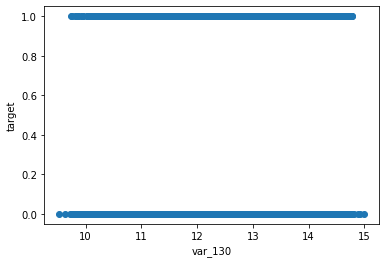

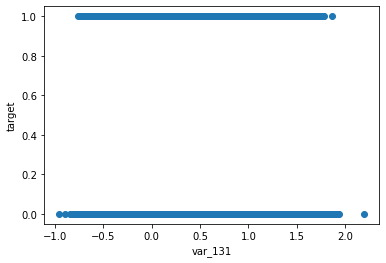

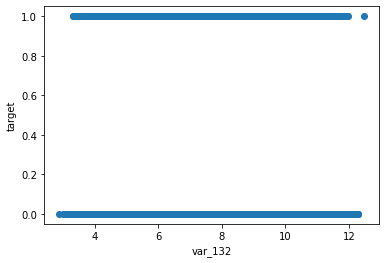

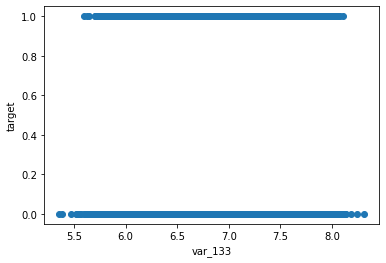

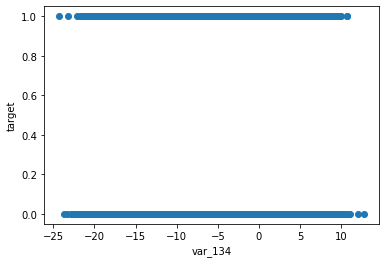

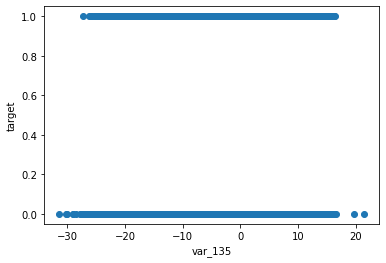

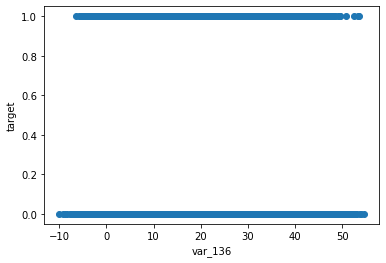

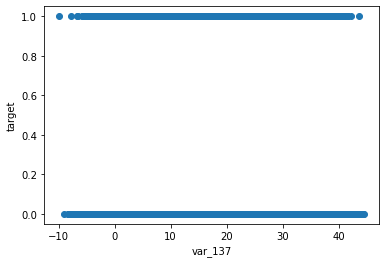

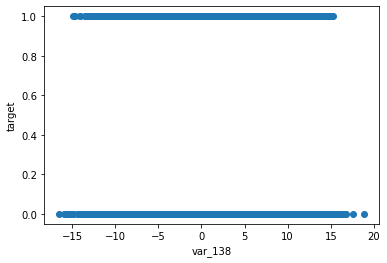

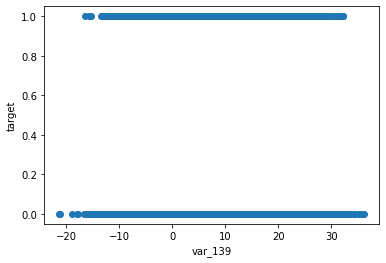

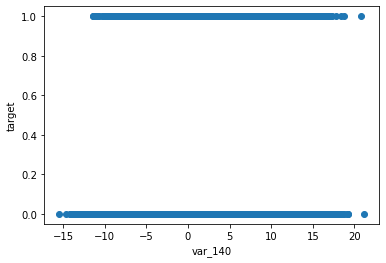

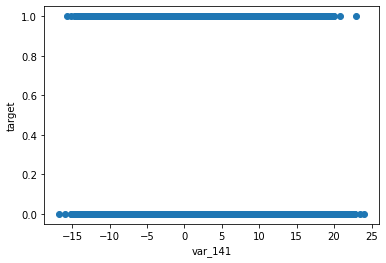

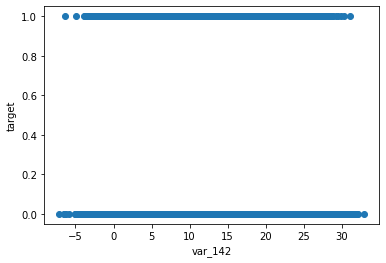

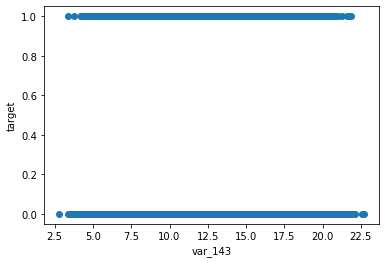

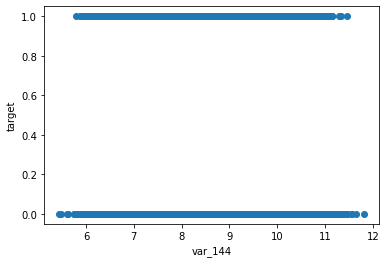

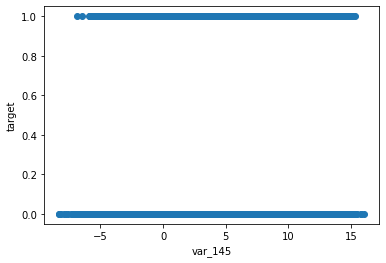

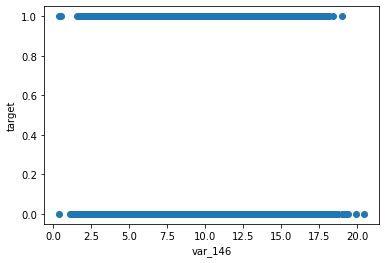

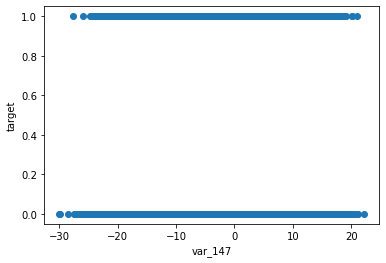

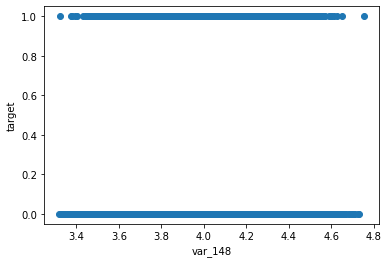

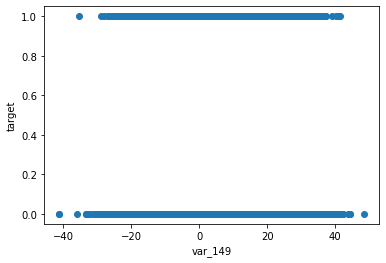

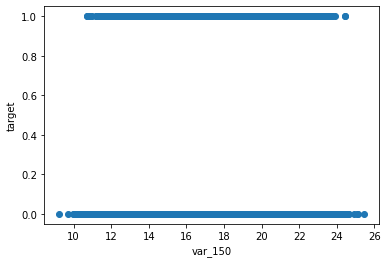

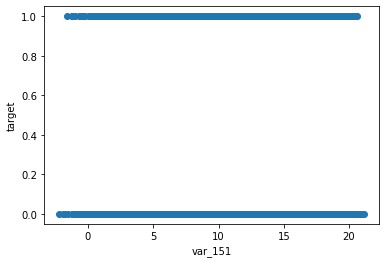

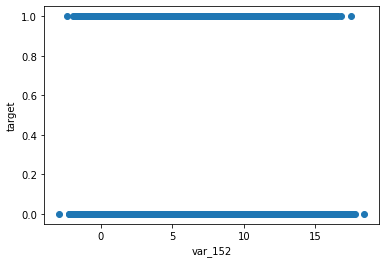

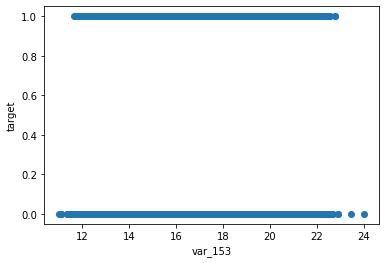

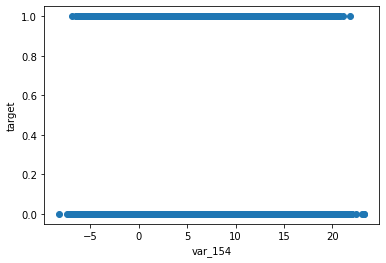

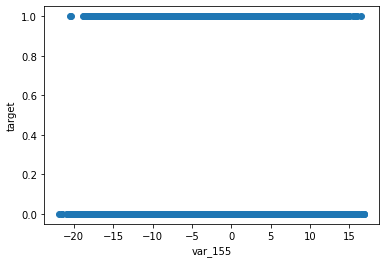

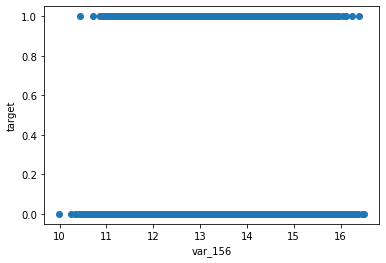

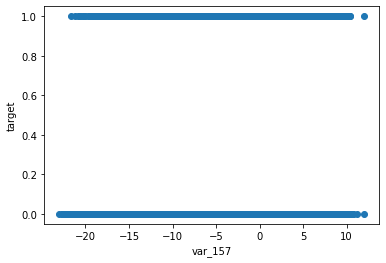

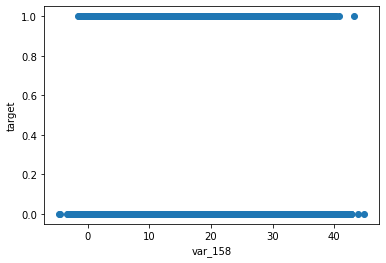

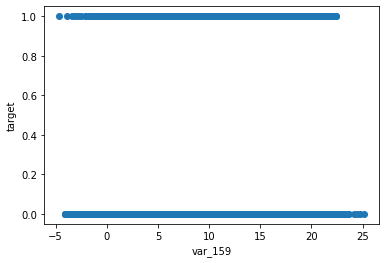

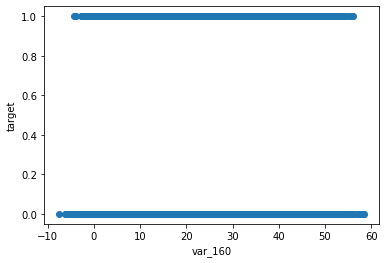

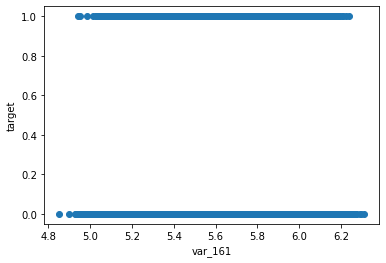

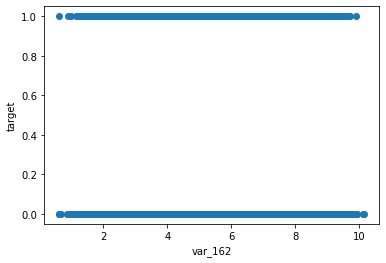

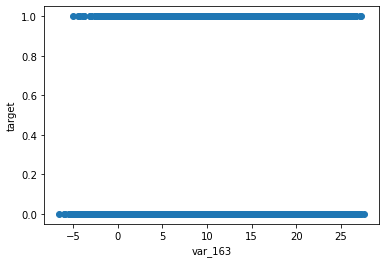

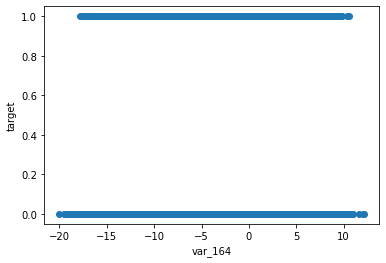

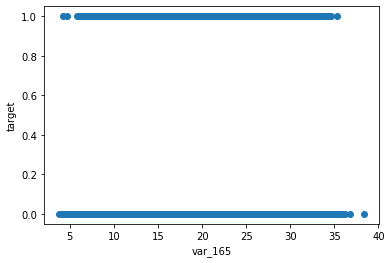

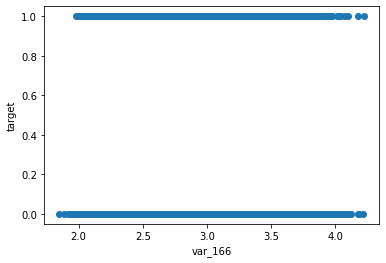

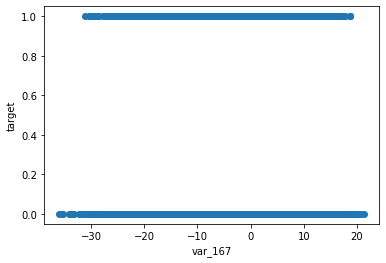

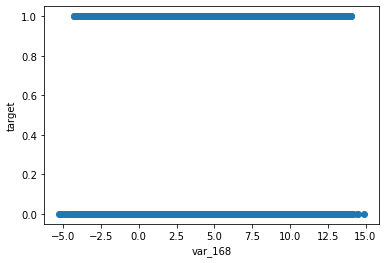

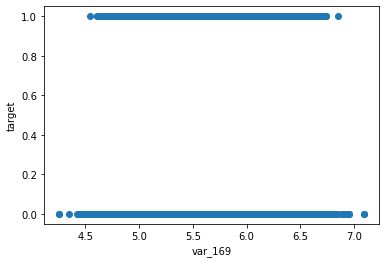

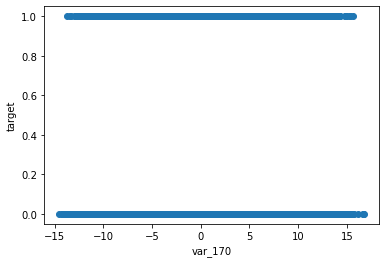

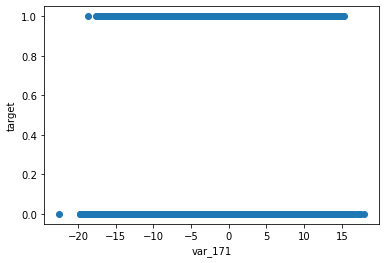

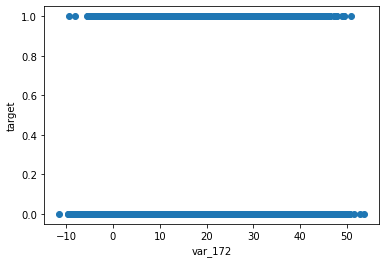

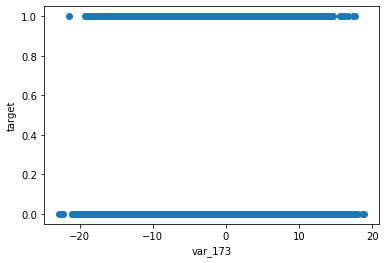

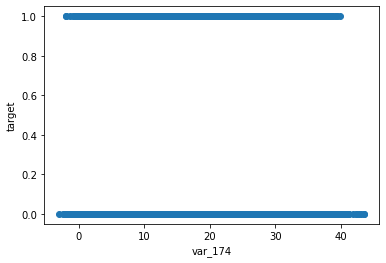

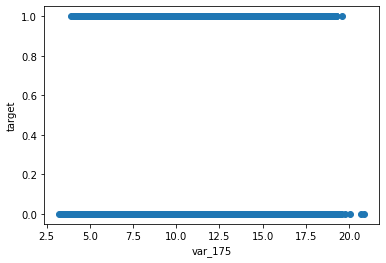

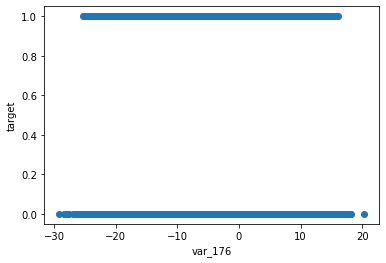

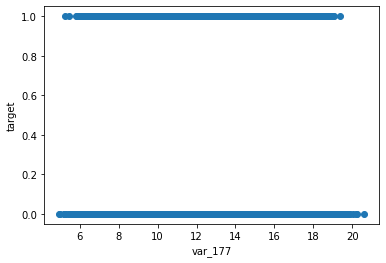

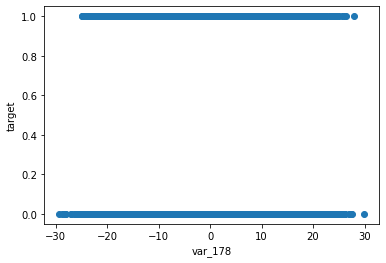

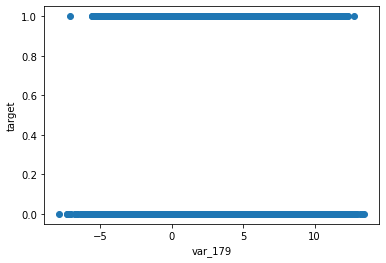

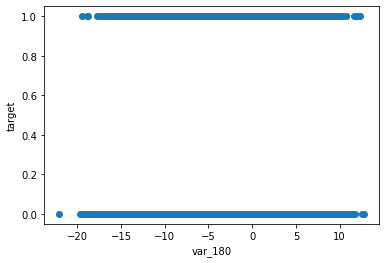

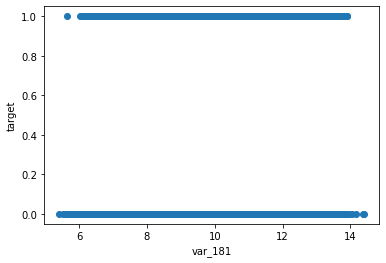

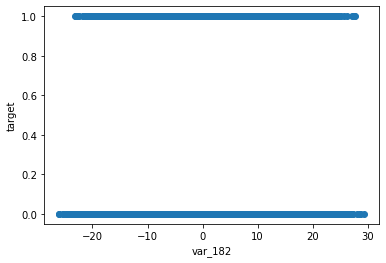

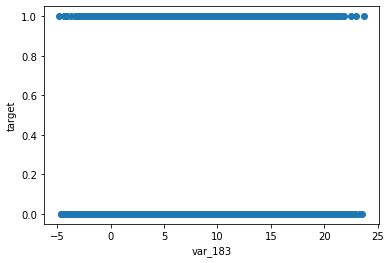

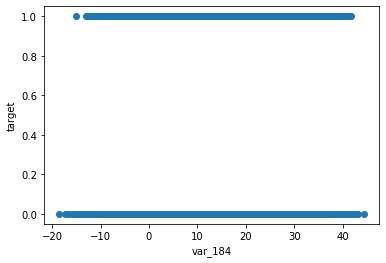

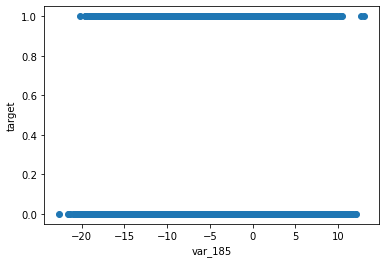

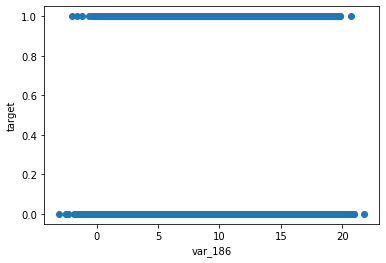

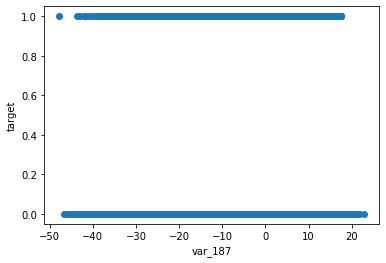

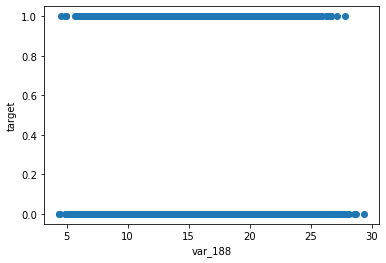

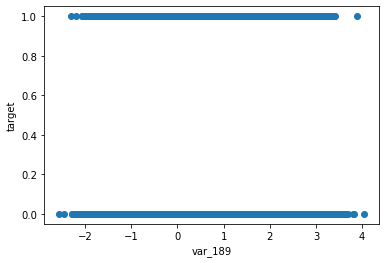

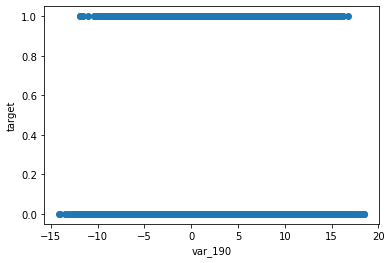

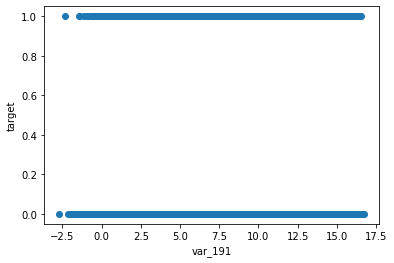

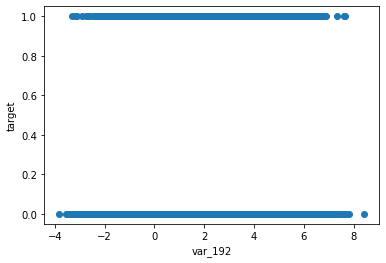

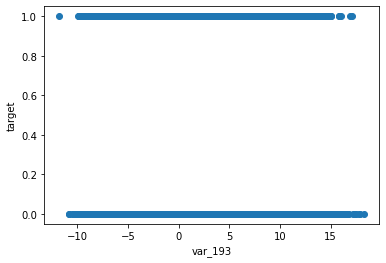

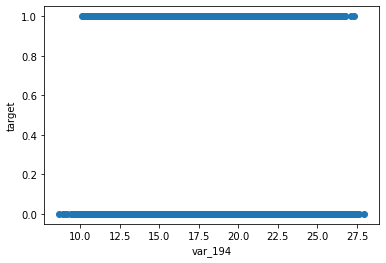

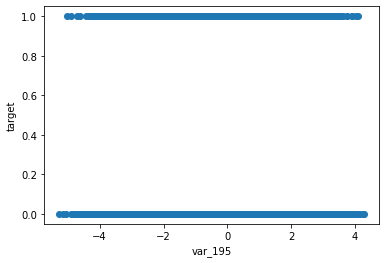

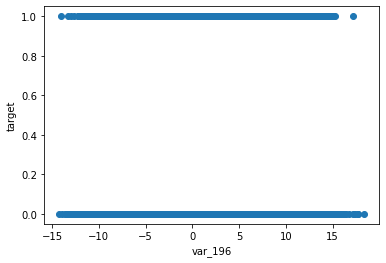

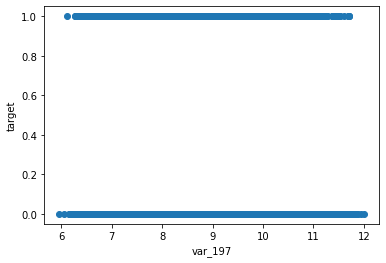

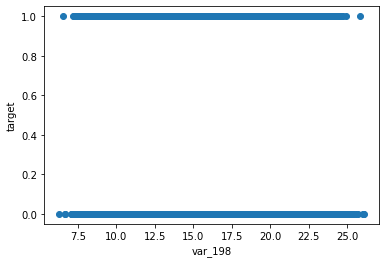

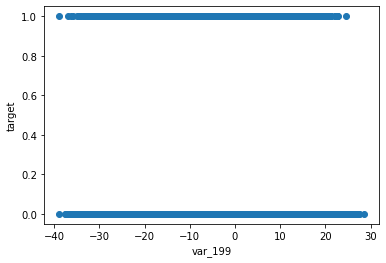

In [46]:
for num, feature in enumerate(continuous_feature):
    plt.scatter(train[feature], train['target']) 
    plt.xlabel(feature)
    plt.ylabel('target')
    plt.show()

C:\Users\Rush\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Rush\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Log Normal'}, xlabel='target'>

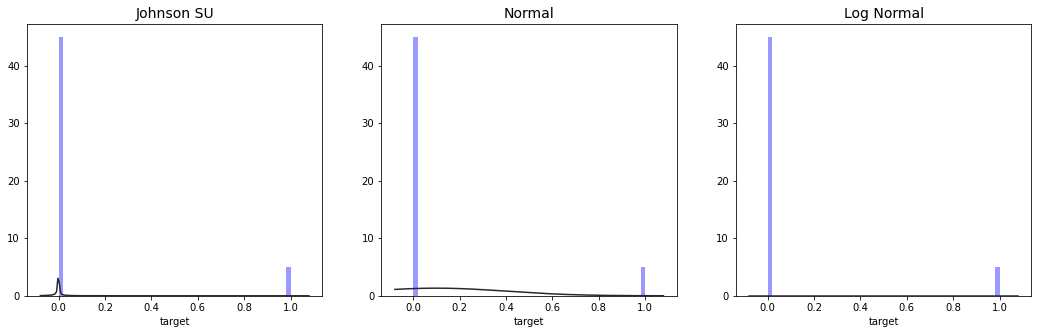

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.lognorm, ax=axes[2])

In [55]:
fig, axes = plt.subplots(40, 5, figsize=(20, 100))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//5, num%5], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//5, num%5], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//5, num%5], color="blue", label="train")
    axes[num//5, num%5].set_title(feature, fontsize=14)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000283FE412700> (for post_execute):


KeyboardInterrupt: 